<a href="https://colab.research.google.com/github/jjefferson2006/DSWP_JJ_altera/blob/main/desafio_analise_5_ordenado_melhor_desempenho_nao_pegar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pycaret

     |████████████████████████████████| 256kB 11.7MB/s 
     |████████████████████████████████| 1.6MB 21.1MB/s 
     |████████████████████████████████| 266kB 47.6MB/s 
     |████████████████████████████████| 13.9MB 46.0MB/s 
     |████████████████████████████████| 148.9MB 89kB/s 
     |████████████████████████████████| 276kB 48.6MB/s 
     |████████████████████████████████| 66.3MB 60kB/s 
     |████████████████████████████████| 1.8MB 44.4MB/s 
     |████████████████████████████████| 6.8MB 38.8MB/s 
     |████████████████████████████████| 102kB 10.1MB/s 
     |████████████████████████████████| 174kB 48.6MB/s 
     |████████████████████████████████| 604kB 39.8MB/s 
     |████████████████████████████████| 71kB 8.3MB/s 
     |████████████████████████████████| 3.1MB 40.4MB/s 
     |████████████████████████████████| 71kB 9.2MB/s 
     |████████████████████████████████| 337kB 49.7MB/s 
     |████████████████████████████████| 1.1MB 34.0MB/s 
     |████████████████████████████████| 61kB 7.4MB/s

In [2]:
from pycaret.classification import *

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, accuracy_score, confusion_matrix

In [4]:
#função pro cross_val
def funcao_cross_val_score(modelo, X_treinamento, y_treinamento, CV):
    # versão com sklearn.model_selection.cross_validate:
    #a_scores_CV = cross_validate(modelo, X_treinamento, y_treinamento, cv = CV, scoring = metodo)
    #print(f'Média das Acurácias calculadas pelo CV....: {100*round(a_scores_CV.mean(),4)}')
    #print(f'std médio das Acurácias calculadas pelo CV: {100*round(a_scores_CV.std(),4)}')
    #return a_scores_CV

    #versão com cross_val_score::
    a_scores_CV = cross_val_score(modelo, X_treinamento, y_treinamento, cv = CV)
    print(f'Média das Acurácias calculadas pelo CV....: {100*round(a_scores_CV.mean(),4)}')
    print(f'std médio das Acurácias calculadas pelo CV: {100*round(a_scores_CV.std(),4)}')
    return a_scores_CV

In [5]:
#grid para cV
def GridSearchOptimizer(modelo, ml_Opt, d_hiperparametros, X_treinamento, y_treinamento, X_teste, y_teste, i_CV, l_colunas):
    ml_GridSearchCV = GridSearchCV(modelo, d_hiperparametros, cv = i_CV, n_jobs = -1, verbose= 10, scoring = 'accuracy')
    start = time()
    ml_GridSearchCV.fit(X_treinamento, y_treinamento)
    tempo_elapsed = time()-start
    print(f"\nGridSearchCV levou {tempo_elapsed:.2f} segundos.")

    # Hiperparâmetros que otimizam a classificação:
    print(f'\nHiperparâmetros otimizados: {ml_GridSearchCV.best_params_}')
    
    if ml_Opt == 'ml_DT2':
        print(f'\nDecisionTreeClassifier *********************************************************************************************************')
        ml_Opt = DecisionTreeClassifier(criterion= ml_GridSearchCV.best_params_['criterion'], 
                                        max_depth= ml_GridSearchCV.best_params_['max_depth'],
                                        max_leaf_nodes= ml_GridSearchCV.best_params_['max_leaf_nodes'],
                                        min_samples_split= ml_GridSearchCV.best_params_['min_samples_leaf'],
                                        min_samples_leaf= ml_GridSearchCV.best_params_['min_samples_split'], 
                                        random_state= i_Seed)
        
    elif ml_Opt == 'ml_RF2':
        print(f'\nRandomForestClassifier *********************************************************************************************************')
        ml_Opt = RandomForestClassifier(bootstrap= ml_GridSearchCV.best_params_['bootstrap'], 
                                        max_depth= ml_GridSearchCV.best_params_['max_depth'],
                                        max_features= ml_GridSearchCV.best_params_['max_features'],
                                        min_samples_leaf= ml_GridSearchCV.best_params_['min_samples_leaf'],
                                        min_samples_split= ml_GridSearchCV.best_params_['min_samples_split'],
                                        n_estimators= ml_GridSearchCV.best_params_['n_estimators'],
                                        random_state= i_Seed)
        
    elif ml_Opt == 'ml_AB2':
        print(f'\nAdaBoostClassifier *********************************************************************************************************')
        ml_Opt = AdaBoostClassifier(algorithm='SAMME.R', 
                                    base_estimator=RandomForestClassifier(bootstrap = False, 
                                                                          max_depth = 10, 
                                                                          max_features = 'auto', 
                                                                          min_samples_leaf = 1, 
                                                                          min_samples_split = 2, 
                                                                          n_estimators = 400), 
                                    learning_rate = ml_GridSearchCV.best_params_['learning_rate'], 
                                    n_estimators = ml_GridSearchCV.best_params_['n_estimators'], 
                                    random_state = i_Seed)
        
    elif ml_Opt == 'ml_GB2':
        print(f'\nGradientBoostingClassifier *********************************************************************************************************')
        ml_Opt = GradientBoostingClassifier(learning_rate = ml_GridSearchCV.best_params_['learning_rate'], 
                                            n_estimators = ml_GridSearchCV.best_params_['n_estimators'], 
                                            max_depth = ml_GridSearchCV.best_params_['max_depth'], 
                                            min_samples_split = ml_GridSearchCV.best_params_['min_samples_split'], 
                                            min_samples_leaf = ml_GridSearchCV.best_params_['min_samples_leaf'], 
                                            max_features = ml_GridSearchCV.best_params_['max_features'])
        
    elif ml_Opt == 'ml_XGB2':
        print(f'\nXGBoostingClassifier *********************************************************************************************************')
        ml_Opt = XGBoostingClassifier(learning_rate= ml_GridSearchCV.best_params_['learning_rate'], 
                                      max_depth= ml_GridSearchCV.best_params_['max_depth'], 
                                      colsample_bytree= ml_GridSearchCV.best_params_['colsample_bytree'], 
                                      subsample= ml_GridSearchCV.best_params_['subsample'], 
                                      gamma= ml_GridSearchCV.best_params_['gamma'], 
                                      min_child_weight= ml_GridSearchCV.best_params_['min_child_weight'])
        
    # Treina novamente usando os hiperparâmetros otimizados...
    ml_Opt.fit(X_treinamento, y_treinamento)

    # Cross-Validation com 10 folds
    print(f'\n********* CROSS-VALIDATION ***********')
    a_scores_CV = funcao_cross_val_score(ml_Opt, X_treinamento, y_treinamento, i_CV)

    # Faz predições com os hiperparâmetros otimizados...
    y_pred = ml_Opt.predict(X_teste)
  
    # Importância das COLUNAS
    print(f'\n********* IMPORTÂNCIA DAS COLUNAS ***********')
    df_importancia_variaveis = pd.DataFrame(zip(l_colunas, ml_Opt.feature_importances_), columns= ['coluna', 'importancia'])
    df_importancia_variaveis = df_importancia_variaveis.sort_values(by= ['importancia'], ascending=False)
    print(df_importancia_variaveis)

    # Matriz de Confusão
    print(f'\n********* CONFUSION MATRIX - PARAMETER TUNNING ***********')
    cf_matrix = confusion_matrix(y_teste, y_pred)
    cf_labels = ['True_Negative', 'False_Positive', 'False_Negative', 'True_Positive']
    cf_categories = ['Zero', 'One']
    mostra_confusion_matrix(cf_matrix, group_names = cf_labels, categories = cf_categories)

    return ml_Opt, ml_GridSearchCV.best_params_

In [6]:
#coluna relevantes
from sklearn.feature_selection import SelectFromModel

def seleciona_colunas_relevantes(modelo, X_treinamento, X_teste, threshold = 0.05):
    # Cria um seletor para selecionar as COLUNAS com importância > threshold
    sfm = SelectFromModel(modelo, threshold)
    
    # Treina o seletor
    sfm.fit(X_treinamento, y_treinamento)

    # Mostra o indice das COLUNAS mais importantes
    print(f'\n********** COLUNAS Relevantes ******')
    print(sfm.get_support(indices=True))

    # Seleciona somente as COLUNAS relevantes
    X_treinamento_I = sfm.transform(X_treinamento)
    X_teste_I = sfm.transform(X_teste)
    return X_treinamento_I, X_teste_I   

In [7]:
#mostra colunas relevantes
def mostra_feature_importances(clf, X_treinamento, y_treinamento=None, 
                             top_n=10, figsize=(8,8), print_table=False, title="Feature Importances"):
    '''
    plot feature importances of a tree-based sklearn estimator
    
    Note: X_treinamento and y_treinamento are pandas DataFrames
    
    Note: Scikit-plot is a lovely package but I sometimes have issues
              1. flexibility/extendibility
              2. complicated models/datasets
          But for many situations Scikit-plot is the way to go
          see https://scikit-plot.readthedocs.io/en/latest/Quickstart.html
    
    Parameters
    ----------
        clf         (sklearn estimator) if not fitted, this routine will fit it
        
        X_treinamento     (pandas DataFrame)
        
        y_treinamento     (pandas DataFrame)  optional
                                        required only if clf has not already been fitted 
        
        top_n       (int)               Plot the top_n most-important features
                                        Default: 10
                                        
        figsize     ((int,int))         The physical size of the plot
                                        Default: (8,8)
        
        print_table (boolean)           If True, print out the table of feature importances
                                        Default: False
        
    Returns
    -------
        the pandas dataframe with the features and their importance
        
    Author
    ------
        George Fisher
    '''
    
    __name__ = "mostra_feature_importances"
    
    import pandas as pd
    import numpy  as np
    import matplotlib.pyplot as plt
    
    from xgboost.core     import XGBoostError
    from lightgbm.sklearn import LightGBMError
    
    try: 
        if not hasattr(clf, 'feature_importances_'):
            clf.fit(X_treinamento.values, y_treinamento.values.ravel())

            if not hasattr(clf, 'feature_importances_'):
                raise AttributeError("{} does not have feature_importances_ attribute".
                                    format(clf.__class__.__name__))
                
    except (XGBoostError, LightGBMError, ValueError):
        clf.fit(X_treinamento.values, y_treinamento.values.ravel())
            
    feat_imp = pd.DataFrame({'importance':clf.feature_importances_})    
    feat_imp['feature'] = X_treinamento.columns
    feat_imp.sort_values(by ='importance', ascending = False, inplace = True)
    feat_imp = feat_imp.iloc[:top_n]
    
    feat_imp.sort_values(by='importance', inplace = True)
    feat_imp = feat_imp.set_index('feature', drop = True)
    feat_imp.plot.barh(title=title, figsize=figsize)
    plt.xlabel('Feature Importance Score')
    plt.show()
    
    if print_table:
        from IPython.display import display
        print("Top {} features in descending order of importance".format(top_n))
        display(feat_imp.sort_values(by = 'importance', ascending = False))
        
    return feat_imp

In [8]:
from sklearn.metrics import accuracy_score # para medir a acurácia do modelo preditivo
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix # para plotar a confusion matrix

from sklearn.model_selection import GridSearchCV # para otimizar os parâmetros dos modelos preditivos
from sklearn.model_selection import cross_val_score # Para o CV (Cross-Validation)
from sklearn.model_selection import cross_validate

from time import time
from operator import itemgetter
from scipy.stats import randint

from sklearn.tree import export_graphviz
#from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

np.set_printoptions(suppress=True)

###carrega o train

In [9]:
url = 'https://raw.githubusercontent.com/jjefferson2006/DSWP_JJ_altera/main/train.csv'
df_churn_train = pd.read_csv(url)
df_churn_train

id  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0     4030  Female              0      No         No    56.0           No   
1     6731    Male              0     Yes        Yes     NaN          Yes   
2     6479  Female              0     Yes         No    60.0          Yes   
3     6861  Female              0      No         No    37.0          Yes   
4     3266    Male              0     Yes        Yes    29.0          Yes   
...    ...     ...            ...     ...        ...     ...          ...   
5629  6684    Male              0      No         No    43.0           No   
5630   604    Male              0      No         No     NaN          Yes   
5631  4803  Female              0      No         No    28.0          Yes   
5632  6317    Male              0     Yes        Yes    63.0          Yes   
5633   103    Male              0      No         No    38.0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
0     No phone service             DSL                  Yes   
1                   No              No  No internet service   
2                  Yes     Fiber optic                   No   
3                  Yes     Fiber optic                   No   
4                   No     Fiber optic                   No   
...                ...             ...                  ...   
5629  No phone service             DSL                   No   
5630               Yes     Fiber optic                   No   
5631                No             DSL                   No   
5632               Yes              No  No internet service   
5633               Yes     Fiber optic                   No   

             OnlineBackup     DeviceProtection          TechSupport  \
0                     Yes                  Yes                  Yes   
1     No internet service  No internet service  No internet service   
2                     Yes                  Yes                  Yes   
3                     Yes                  Yes                   No   
4                      No                   No                   No   
...                   ...                  ...                  ...   
5629                   No                  Yes                  Yes   
5630                  Yes                  Yes                  Yes   
5631                  Yes                   No                  Yes   
5632  No internet service  No internet service  No internet service   
5633                   No                  Yes                  Yes   

              StreamingTV      StreamingMovies        Contract  \
0                      No                   No        Two year   
1     No internet service  No internet service        One year   
2                     Yes                  Yes        Two year   
3                     Yes                  Yes  Month-to-month   
4                      No                   No  Month-to-month   
...                   ...                  ...             ...   
5629                   No                  Yes        One year   
5630                  Yes                  Yes        Two year   
5631                   No                   No  Month-to-month   
5632  No internet service  No internet service        Two year   
5633                  Yes                   No        One year   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0                  No                        NaN           45.05       2560.1   
1                  No               Mailed check           19.65       332.65   
2                 Yes    Credit card (automatic)          110.80       6640.7   
3                 Yes  Bank transfer (automatic)          101.90      3545.35   
4                 Yes           Electronic check           70.75       1974.8   
...               ...                        ...             ...          ...   
5629               No           Electronic check           44.15       1931.3   
5630               No           

In [10]:
#Normalizar as colunas
df_churn_train.columns = [col.lower() for col in df_churn_train.columns]
df_churn_train.head()

id  gender  seniorcitizen partner dependents  tenure phoneservice  \
0  4030  Female              0      No         No    56.0           No   
1  6731    Male              0     Yes        Yes     NaN          Yes   
2  6479  Female              0     Yes         No    60.0          Yes   
3  6861  Female              0      No         No    37.0          Yes   
4  3266    Male              0     Yes        Yes    29.0          Yes   

      multiplelines internetservice       onlinesecurity         onlinebackup  \
0  No phone service             DSL                  Yes                  Yes   
1                No              No  No internet service  No internet service   
2               Yes     Fiber optic                   No                  Yes   
3               Yes     Fiber optic                   No                  Yes   
4                No     Fiber optic                   No                   No   

      deviceprotection          techsupport          streamingtv  \
0                  Yes                  Yes                   No   
1  No internet service  No internet service  No internet service   
2                  Yes                  Yes                  Yes   
3                  Yes                   No                  Yes   
4                   No                   No                   No   

       streamingmovies        contract paperlessbilling  \
0                   No        Two year               No   
1  No internet service        One year               No   
2                  Yes        Two year              Yes   
3                  Yes  Month-to-month              Yes   
4                   No  Month-to-month              Yes   

               paymentmethod  monthlycharges totalcharges  churn  
0                        NaN           45.05       2560.1      0  
1               Mailed check           19.65       332.65      0  
2    Credit card (automatic)          110.80       6640.7      0  
3  Bank transfer (automatic)          101.90      3545.35      1  
4           Electronic check           70.75       1974.8      1

In [11]:
df_churn_train.dtypes

id                    int64
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure              float64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
churn                 int64
dtype: object

In [12]:
df_churn_train.isna().sum()

id                    0
gender                0
seniorcitizen         0
partner               0
dependents          218
tenure              461
phoneservice          0
multiplelines         0
internetservice       0
onlinesecurity        0
onlinebackup          0
deviceprotection      0
techsupport           0
streamingtv           0
streamingmovies       0
contract              0
paperlessbilling      0
paymentmethod        99
monthlycharges        0
totalcharges          0
churn                 0
dtype: int64

In [13]:
#função mostra isna

def mostra_isna(df):
    l_rec_trei = df.columns
    d = 0
    for i in l_rec_trei:
        f = df[i].isna().sum()
        g = df[i].dtypes
        if f != 0:
            d = d + 1
            h = f/df.shape[0]*100
            print('{} = {}: percentual = {} : {}'.format(i, df[i].isna().sum(), h, g))
    print('qt de colunas con isna:{}'.format(d))
    

In [14]:
mostra_isna(df_churn_train)

dependents = 218: percentual = 3.8693645722399714 : object
tenure = 461: percentual = 8.182463613773518 : float64
paymentmethod = 99: percentual = 1.7571884984025559 : object
qt de colunas con isna:3


In [15]:
df_churn_train.shape

(5634, 21)

In [16]:
df_churn_train['paymentmethod'].value_counts()

Electronic check             1887
Mailed check                 1272
Bank transfer (automatic)    1212
Credit card (automatic)      1164
Name: paymentmethod, dtype: int64

###train: pay depent

In [17]:
df_churn_train['paymentmethod'].fillna('Electronic check', inplace=True)
df_churn_train['dependents'].fillna('No', inplace=True)

In [18]:
df_churn_train['totalcharges'] = df_churn_train['totalcharges'].str.replace(',', '.')
df_churn_train['totalcharges'] = pd.to_numeric(df_churn_train['totalcharges'], errors= 'coerce')


In [19]:
df_churn_train['tenure_esti']=round(df_churn_train['totalcharges']/df_churn_train['monthlycharges'],2)


In [20]:
df_churn_train['tenure_rou']=round(df_churn_train['tenure_esti'])

In [21]:
l_tot_ten = list(df_churn_train[df_churn_train['tenure'].isna()].index)
for i in l_tot_ten:
    df_churn_train['tenure'][i] = df_churn_train['tenure_rou'][i]


In [22]:
df_churn_train.drop(columns=['tenure_esti','tenure_rou'], inplace=True)

In [23]:
df_churn_train.head()

id  gender  seniorcitizen partner dependents  tenure phoneservice  \
0  4030  Female              0      No         No    56.0           No   
1  6731    Male              0     Yes        Yes    17.0          Yes   
2  6479  Female              0     Yes         No    60.0          Yes   
3  6861  Female              0      No         No    37.0          Yes   
4  3266    Male              0     Yes        Yes    29.0          Yes   

      multiplelines internetservice       onlinesecurity         onlinebackup  \
0  No phone service             DSL                  Yes                  Yes   
1                No              No  No internet service  No internet service   
2               Yes     Fiber optic                   No                  Yes   
3               Yes     Fiber optic                   No                  Yes   
4                No     Fiber optic                   No                   No   

      deviceprotection          techsupport          streamingtv  \
0                  Yes                  Yes                   No   
1  No internet service  No internet service  No internet service   
2                  Yes                  Yes                  Yes   
3                  Yes                   No                  Yes   
4                   No                   No                   No   

       streamingmovies        contract paperlessbilling  \
0                   No        Two year               No   
1  No internet service        One year               No   
2                  Yes        Two year              Yes   
3                  Yes  Month-to-month              Yes   
4                   No  Month-to-month              Yes   

               paymentmethod  monthlycharges  totalcharges  churn  
0           Electronic check           45.05       2560.10      0  
1               Mailed check           19.65        332.65      0  
2    Credit card (automatic)          110.80       6640.70      0  
3  Bank transfer (automatic)          101.90       3545.35      1  
4           Electronic check           70.75       1974.80      1

In [24]:
df_churn_train.isna().sum()

id                  0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        8
churn               0
dtype: int64

In [25]:
l_charg = list(df_churn_train[df_churn_train['totalcharges'].isna()].index)
l_charg

[161, 416, 1766, 2145, 3375, 3404, 4008, 5151]

In [26]:
for i in l_charg:
    df_churn_train['totalcharges'][i] = 0.0

In [27]:
df_churn_train.isna().sum()

id                  0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

###Train: poe  'no phone service' em no e no internet service no no

In [28]:
df_churn_train.onlinesecurity.replace(['No internet service'], ['No'], inplace=True)
df_churn_train.multiplelines.replace(['No phone service'], ['No'], inplace=True)
df_churn_train.onlinebackup.replace(['No internet service'], ['No'], inplace=True)
df_churn_train.deviceprotection.replace(['No internet service'], ['No'], inplace=True)
df_churn_train.techsupport.replace(['No internet service'], ['No'], inplace=True)
df_churn_train.streamingtv.replace(['No internet service'], ['No'], inplace=True)
df_churn_train.streamingmovies.replace(['No internet service'], ['No'], inplace=True)

In [29]:
df_churn_train.gender.replace(['Female', 'Male'], [1, 0], inplace=True)
df_churn_train.partner.replace(['Yes', 'No'], [1, 0], inplace=True)
df_churn_train.dependents.replace(['Yes', 'No'], [1, 0], inplace=True)


In [30]:
#df_churn_train.multiplelines.replace(['No', 'Yes'], [0,1], inplace=True)
#df_churn_train.onlinesecurity.replace(['No', 'Yes'], [0,1], inplace=True) 
df_churn_train.onlinebackup.replace(['No', 'Yes'], [0,1], inplace=True)
#df_churn_train.deviceprotection.replace(['No', 'Yes'], [0,1], inplace=True)
#df_churn_train.techsupport.replace(['No', 'Yes'], [0,1], inplace=True)
df_churn_train.streamingtv.replace(['No', 'Yes'], [0,1], inplace=True)
df_churn_train.streamingmovies.replace(['No', 'Yes'], [0,1], inplace=True)

In [31]:
df_churn_train.head()

id  gender  seniorcitizen  partner  dependents  tenure phoneservice  \
0  4030       1              0        0           0    56.0           No   
1  6731       0              0        1           1    17.0          Yes   
2  6479       1              0        1           0    60.0          Yes   
3  6861       1              0        0           0    37.0          Yes   
4  3266       0              0        1           1    29.0          Yes   

  multiplelines internetservice onlinesecurity  onlinebackup deviceprotection  \
0            No             DSL            Yes             1              Yes   
1            No              No             No             0               No   
2           Yes     Fiber optic             No             1              Yes   
3           Yes     Fiber optic             No             1              Yes   
4            No     Fiber optic             No             0               No   

  techsupport  streamingtv  streamingmovies        contract paperlessbilling  \
0         Yes            0                0        Two year               No   
1          No            0                0        One year               No   
2         Yes            1                1        Two year              Yes   
3          No            1                1  Month-to-month              Yes   
4          No            0                0  Month-to-month              Yes   

               paymentmethod  monthlycharges  totalcharges  churn  
0           Electronic check           45.05       2560.10      0  
1               Mailed check           19.65        332.65      0  
2    Credit card (automatic)          110.80       6640.70      0  
3  Bank transfer (automatic)          101.90       3545.35      1  
4           Electronic check           70.75       1974.80      1

In [32]:
dummy_tr=pd.get_dummies(df_churn_train[['phoneservice','internetservice','contract','paperlessbilling','paymentmethod','multiplelines', 'onlinesecurity', 'techsupport', 'deviceprotection' ]])
dummy_tr

phoneservice_No  phoneservice_Yes  internetservice_DSL  \
0                   1                 0                    1   
1                   0                 1                    0   
2                   0                 1                    0   
3                   0                 1                    0   
4                   0                 1                    0   
...               ...               ...                  ...   
5629                1                 0                    1   
5630                0                 1                    0   
5631                0                 1                    1   
5632                0                 1                    0   
5633                0                 1                    0   

      internetservice_Fiber optic  internetservice_No  \
0                               0                   0   
1                               0                   1   
2                               1                   0   
3                               1                   0   
4                               1                   0   
...                           ...                 ...   
5629                            0                   0   
5630                            1                   0   
5631                            0                   0   
5632                            0                   1   
5633                            1                   0   

      contract_Month-to-month  contract_One year  contract_Two year  \
0                           0                  0                  1   
1                           0                  1                  0   
2                           0                  0                  1   
3                           1                  0                  0   
4                           1                  0                  0   
...                       ...                ...                ...   
5629                        0                  1                  0   
5630                        0                  0                  1   
5631                        1                  0                  0   
5632                        0                  0                  1   
5633                        0                  1                  0   

      paperlessbilling_No  paperlessbilling_Yes  \
0                       1                     0   
1                       1                     0   
2                       0                     1   
3                       0                     1   
4                       0                     1   
...                   ...                   ...   
5629                    1                     0   
5630                    1                     0   
5631                    1                     0   
5632                    1                     0   
5633                    1                     0   

      paymentmethod_Bank transfer (automatic)  \
0                                           0   
1                                           0   
2                                           0   
3                                           1   
4                                           0   
...                                       ...   
5629                                        0   
5630                                        0   
5631                                        1   
5632                                        0   
5633                                        1   

      paymentmethod_Credit card (automatic)  paymentmethod_Electronic check  \
0                                         0                               1   
1                                         0                               0   
2                                         1                               0   
3                                         0                               0   
4                                         0                               1   
...                    

In [33]:
df_train_dumy=pd.concat([df_churn_train,dummy_tr],axis=1)
df_train_dumy

id  gender  seniorcitizen  partner  dependents  tenure phoneservice  \
0     4030       1              0        0           0    56.0           No   
1     6731       0              0        1           1    17.0          Yes   
2     6479       1              0        1           0    60.0          Yes   
3     6861       1              0        0           0    37.0          Yes   
4     3266       0              0        1           1    29.0          Yes   
...    ...     ...            ...      ...         ...     ...          ...   
5629  6684       0              0        0           0    43.0           No   
5630   604       0              0        0           0    45.0          Yes   
5631  4803       1              0        0           0    28.0          Yes   
5632  6317       0              0        1           1    63.0          Yes   
5633   103       0              0        0           0    38.0          Yes   

     multiplelines internetservice onlinesecurity  onlinebackup  \
0               No             DSL            Yes             1   
1               No              No             No             0   
2              Yes     Fiber optic             No             1   
3              Yes     Fiber optic             No             1   
4               No     Fiber optic             No             0   
...            ...             ...            ...           ...   
5629            No             DSL             No             0   
5630           Yes     Fiber optic             No             1   
5631            No             DSL             No             1   
5632           Yes              No             No             0   
5633           Yes     Fiber optic             No             0   

     deviceprotection techsupport  streamingtv  streamingmovies  \
0                 Yes         Yes            0                0   
1                  No          No            0                0   
2                 Yes         Yes            1                1   
3                 Yes          No            1                1   
4                  No          No            0                0   
...               ...         ...          ...              ...   
5629              Yes         Yes            0                1   
5630              Yes         Yes            1                1   
5631               No         Yes            0                0   
5632               No          No            0                0   
5633              Yes         Yes            1                0   

            contract paperlessbilling              paymentmethod  \
0           Two year               No           Electronic check   
1           One year               No               Mailed check   
2           Two year              Yes    Credit card (automatic)   
3     Month-to-month              Yes  Bank transfer (automatic)   
4     Month-to-month              Yes           Electronic check   
...              ...              ...                        ...   
5629        One year               No           Electronic check   
5630        Two year               No           Electronic check   
5631  Month-to-month               No  Bank transfer (automatic)   
5632        Two year               No               Mailed check   
5633        One year               No  Bank transfer (automatic)   

      monthlycharges  totalcharges  churn  phoneservice_No  phoneservice_Yes  \
0              45.05       2560.10      0                1                 0   
1              19.65        332.65      0                0                 1   
2             110.80       6640.70      0                0                 1   
3             101.90       3545.35      1                0                 1   
4              70.75       1974.80      1                0                 1   
...              ...           ...    ...              ...               ...   
5629           44.15       1931.30      0                1              

In [34]:
df_train_dumy.drop(columns=['phoneservice','internetservice','contract','paperlessbilling','paymentmethod', 'onlinesecurity', 'multiplelines', 'techsupport', 'deviceprotection'], inplace = True)

In [35]:
df_train_dumy.isna().sum()

id                                         0
gender                                     0
seniorcitizen                              0
partner                                    0
dependents                                 0
tenure                                     0
onlinebackup                               0
streamingtv                                0
streamingmovies                            0
monthlycharges                             0
totalcharges                               0
churn                                      0
phoneservice_No                            0
phoneservice_Yes                           0
internetservice_DSL                        0
internetservice_Fiber optic                0
internetservice_No                         0
contract_Month-to-month                    0
contract_One year                          0
contract_Two year                          0
paperlessbilling_No                        0
paperlessbilling_Yes                       0
paymentmet

In [36]:
df_train_dumy

id  gender  seniorcitizen  partner  dependents  tenure  onlinebackup  \
0     4030       1              0        0           0    56.0             1   
1     6731       0              0        1           1    17.0             0   
2     6479       1              0        1           0    60.0             1   
3     6861       1              0        0           0    37.0             1   
4     3266       0              0        1           1    29.0             0   
...    ...     ...            ...      ...         ...     ...           ...   
5629  6684       0              0        0           0    43.0             0   
5630   604       0              0        0           0    45.0             1   
5631  4803       1              0        0           0    28.0             1   
5632  6317       0              0        1           1    63.0             0   
5633   103       0              0        0           0    38.0             0   

      streamingtv  streamingmovies  monthlycharges  totalcharges  churn  \
0               0                0           45.05       2560.10      0   
1               0                0           19.65        332.65      0   
2               1                1          110.80       6640.70      0   
3               1                1          101.90       3545.35      1   
4               0                0           70.75       1974.80      1   
...           ...              ...             ...           ...    ...   
5629            0                1           44.15       1931.30      0   
5630            1                1          108.65       4903.20      0   
5631            0                0           54.65       1517.50      0   
5632            0                0           25.25       1573.05      0   
5633            1                0           95.00       3605.60      0   

      phoneservice_No  phoneservice_Yes  internetservice_DSL  \
0                   1                 0                    1   
1                   0                 1                    0   
2                   0                 1                    0   
3                   0                 1                    0   
4                   0                 1                    0   
...               ...               ...                  ...   
5629                1                 0                    1   
5630                0                 1                    0   
5631                0                 1                    1   
5632                0                 1                    0   
5633                0                 1                    0   

      internetservice_Fiber optic  internetservice_No  \
0                               0                   0   
1                               0                   1   
2                               1                   0   
3                               1                   0   
4                               1                   0   
...                           ...                 ...   
5629                            0                   0   
5630                            1                   0   
5631                            0                   0   
5632                            0                   1   
5633                            1                   0   

      contract_Month-to-month  contract_One year  contract_Two year  \
0                           0                  0                  1   
1                           0                  1                  0   
2                           0                  0                  1   
3                           1                  0                  0   
4                           1                  0                  0   
...                       ...                ...                ...   
5629                        0                  1                  0   
5630                        0                  0                  1   
5631                        1                  0     

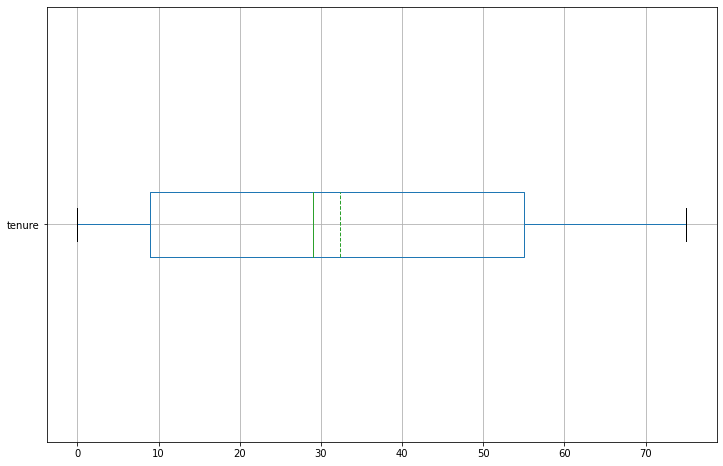

In [ ]:
df_train_dumy[['tenure']].plot(kind = 'box',showmeans = True, meanline = True,
                      grid = True, figsize = (12,8),vert = False)

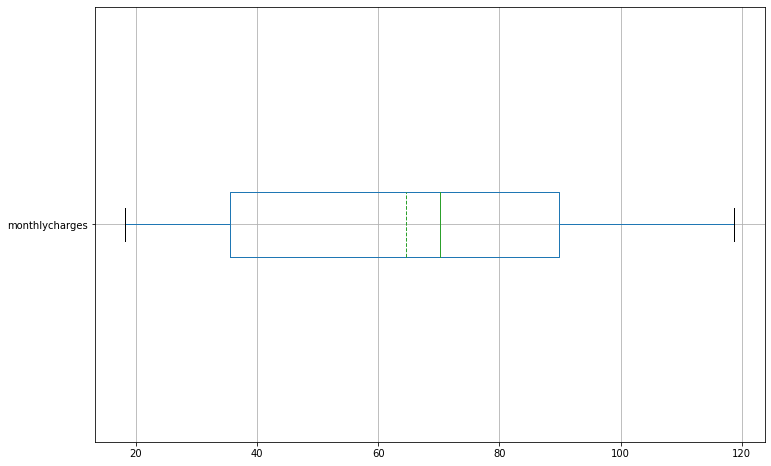

In [ ]:
df_train_dumy[['monthlycharges']].plot(kind = 'box',showmeans = True, meanline = True,
                      grid = True, figsize = (12,8),vert = False)

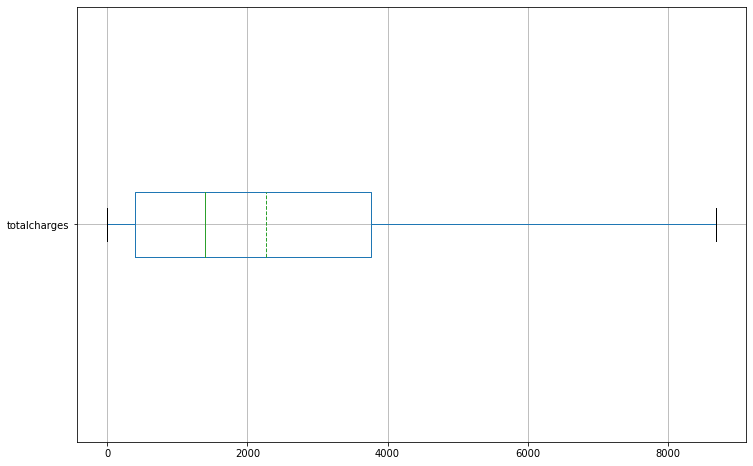

In [ ]:
df_train_dumy[['totalcharges']].plot(kind = 'box',showmeans = True, meanline = True,
                      grid = True, figsize = (12,8),vert = False)

In [ ]:
'''df_st = df_train_dumy[['tenure', 'monthlycharges','totalcharges' ]].copy()

In [ ]:
'''df_st

tenure  monthlycharges  totalcharges
0       56.0           45.05       2560.10
1       17.0           19.65        332.65
2       60.0          110.80       6640.70
3       37.0          101.90       3545.35
4       29.0           70.75       1974.80
...      ...             ...           ...
5629    43.0           44.15       1931.30
5630    45.0          108.65       4903.20
5631    28.0           54.65       1517.50
5632    63.0           25.25       1573.05
5633    38.0           95.00       3605.60

[5634 rows x 3 columns]

In [ ]:
'''l_tr_dumy = list(df_train_dumy.columns)
l_tr_dumy

['id',
 'gender',
 'seniorcitizen',
 'partner',
 'dependents',
 'tenure',
 'multiplelines',
 'onlinesecurity',
 'onlinebackup',
 'deviceprotection',
 'techsupport',
 'streamingtv',
 'streamingmovies',
 'monthlycharges',
 'totalcharges',
 'churn',
 'phoneservice_No',
 'phoneservice_Yes',
 'internetservice_DSL',
 'internetservice_Fiber optic',
 'internetservice_No',
 'contract_Month-to-month',
 'contract_One year',
 'contract_Two year',
 'paperlessbilling_No',
 'paperlessbilling_Yes',
 'paymentmethod_Bank transfer (automatic)',
 'paymentmethod_Credit card (automatic)',
 'paymentmethod_Electronic check',
 'paymentmethod_Mailed check']

In [ ]:
'''df_train_dumy.drop(columns=['id', 'gender', 'partner', 'dependents', 'tenure', 'multiplelines', 'onlinebackup',
                            'deviceprotection', 'techsupport', 'streamingtv', 'monthlycharges', 'totalcharges',
                            'internetservice_DSL', 'internetservice_No',
                            'contract_One year', 'contract_Two year',
                            'paymentmethod_Bank transfer (automatic)', 'paymentmethod_Credit card (automatic)', 'paymentmethod_Electronic check'], inplace=True)

In [ ]:
['seniorcitizen', 'onlinesecurity',
 'streamingmovies',
  'churn',
 'phoneservice_No',
 'phoneservice_Yes',
 'internetservice_Fiber optic',
 'contract_Month-to-month',
 'paperlessbilling_No',
 'paperlessbilling_Yes',
 'paymentmethod_Electronic check']

In [37]:
df_train_dumy.head()

id  gender  seniorcitizen  partner  dependents  tenure  onlinebackup  \
0  4030       1              0        0           0    56.0             1   
1  6731       0              0        1           1    17.0             0   
2  6479       1              0        1           0    60.0             1   
3  6861       1              0        0           0    37.0             1   
4  3266       0              0        1           1    29.0             0   

   streamingtv  streamingmovies  monthlycharges  totalcharges  churn  \
0            0                0           45.05       2560.10      0   
1            0                0           19.65        332.65      0   
2            1                1          110.80       6640.70      0   
3            1                1          101.90       3545.35      1   
4            0                0           70.75       1974.80      1   

   phoneservice_No  phoneservice_Yes  internetservice_DSL  \
0                1                 0                    1   
1                0                 1                    0   
2                0                 1                    0   
3                0                 1                    0   
4                0                 1                    0   

   internetservice_Fiber optic  internetservice_No  contract_Month-to-month  \
0                            0                   0                        0   
1                            0                   1                        0   
2                            1                   0                        0   
3                            1                   0                        1   
4                            1                   0                        1   

   contract_One year  contract_Two year  paperlessbilling_No  \
0                  0                  1                    1   
1                  1                  0                    1   
2                  0                  1                    0   
3                  0                  0                    0   
4                  0                  0                    0   

   paperlessbilling_Yes  paymentmethod_Bank transfer (automatic)  \
0                     0                                        0   
1                     0                                        0   
2                     1                                        0   
3                     1                                        1   
4                     1                                        0   

   paymentmethod_Credit card (automatic)  paymentmethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      1                               0   
3                                      0                               0   
4                                      0                               1   

   paymentmethod_Mailed check  multiplelines_No  multiplelines_Yes  \
0                           0                 1                  0   
1                           1                 1                  0   
2                           0                 0                  1   
3                           0                 0                  1   
4                           0                 1                  0   

   onlinesecurity_No  onlinesecurity_Yes  techsupport_No  techsupport_Yes  \
0                  0                   1               0                1   
1                  1                   0               1                0   
2                  1                   0               0                1   
3                  1                   0               1                0   
4                  1                   0               1                0   

   deviceprotection_No  deviceprotection_Yes  
0                    0                     1  
1                    1                

In [38]:
from scipy import stats


In [39]:
correlacoes = df_train_dumy.corr()



In [40]:
correlacoes


id    gender  seniorcitizen  \
id                                       1.000000  0.005947      -0.005344   
gender                                   0.005947  1.000000       0.002990   
seniorcitizen                           -0.005344  0.002990       1.000000   
partner                                  0.001929  0.007471       0.018942   
dependents                               0.003902 -0.002573      -0.205459   
tenure                                   0.002524 -0.008574       0.007509   
onlinebackup                             0.008065  0.015663       0.057399   
streamingtv                             -0.002111  0.002426       0.106479   
streamingmovies                         -0.019964  0.002512       0.116753   
monthlycharges                          -0.013354  0.003511       0.215351   
totalcharges                            -0.003117 -0.005655       0.093825   
churn                                    0.015188  0.000797       0.161488   
phoneservice_No                          0.024654 -0.001033      -0.009136   
phoneservice_Yes                        -0.024654  0.001033       0.009136   
internetservice_DSL                      0.017658 -0.004751      -0.102873   
internetservice_Fiber optic             -0.014007  0.002450       0.249942   
internetservice_No                      -0.003554  0.002541      -0.181677   
contract_Month-to-month                 -0.005318  0.012493       0.144083   
contract_One year                       -0.006060 -0.020192      -0.052508   
contract_Two year                        0.011976  0.004742      -0.117537   
paperlessbilling_No                      0.002960 -0.005634      -0.155394   
paperlessbilling_Yes                    -0.002960  0.005634       0.155394   
paymentmethod_Bank transfer (automatic) -0.016212  0.032730      -0.026387   
paymentmethod_Credit card (automatic)   -0.005079 -0.014371      -0.011642   
paymentmethod_Electronic check           0.008005 -0.005737       0.167635   
paymentmethod_Mailed check               0.011704 -0.011697      -0.154348   
multiplelines_No                         0.009133 -0.001849      -0.138352   
multiplelines_Yes                       -0.009133  0.001849       0.138352   
onlinesecurity_No                        0.006920 -0.019400       0.040954   
onlinesecurity_Yes                      -0.006920  0.019400      -0.040954   
techsupport_No                          -0.017120 -0.003676       0.062912   
techsupport_Yes                          0.017120  0.003676      -0.062912   
deviceprotection_No                      0.014334  0.003021      -0.047854   
deviceprotection_Yes                    -0.014334 -0.003021       0.047854   

                                          partner  dependents    tenure  \
id                                       0.001929    0.003902  0.002524   
gender                                   0.007471   -0.002573 -0.008574   
seniorcitizen                            0.018942   -0.205459  0.007509   
partner                                  1.000000    0.437588  0.386215   
dependents                               0.437588    1.000000  0.153433   
tenure                                   0.386215    0.153433  1.000000   
onlinebackup                             0.136336    0.029203  0.350547   
streamingtv                              0.130445   -0.008954  0.281074   
streamingmovies                          0.116604   -0.032522  0.287069   
monthlycharges                           0.096741   -0.098794  0.244726   
totalcharges                             0.319301    0.061899  0.825807   
churn                                   -0.164049   -0.163041 -0.358069   
phoneservice_No                         -0.024696   -0.006613 -0.013955   
phoneservice_Yes                         0.024696    0.006613  0.013955   
internetservice_DSL                      0.004516    0.062271  0.014552   
internetservice_Fiber optic             -0.005388   -0.160538  0.013974   
internetservice_No                       

In [41]:
correlacoes[['churn']]

churn
id                                       0.015188
gender                                   0.000797
seniorcitizen                            0.161488
partner                                 -0.164049
dependents                              -0.163041
tenure                                  -0.358069
onlinebackup                            -0.082258
streamingtv                              0.067891
streamingmovies                          0.062952
monthlycharges                           0.202742
totalcharges                            -0.199293
churn                                    1.000000
phoneservice_No                         -0.019574
phoneservice_Yes                         0.019574
internetservice_DSL                     -0.135757
internetservice_Fiber optic              0.323234
internetservice_No                      -0.231812
contract_Month-to-month                  0.414040
contract_One year                       -0.186326
contract_Two year                       -0.303915
paperlessbilling_No                     -0.203485
paperlessbilling_Yes                     0.203485
paymentmethod_Bank transfer (automatic) -0.108212
paymentmethod_Credit card (automatic)   -0.128953
paymentmethod_Electronic check           0.288627
paymentmethod_Mailed check              -0.098585
multiplelines_No                        -0.038886
multiplelines_Yes                        0.038886
onlinesecurity_No                        0.179454
onlinesecurity_Yes                      -0.179454
techsupport_No                           0.164472
techsupport_Yes                         -0.164472
deviceprotection_No                      0.068727
deviceprotection_Yes                    -0.068727

In [42]:
correlacoes[correlacoes['churn']> 0.02]

id    gender  seniorcitizen   partner  \
seniorcitizen                  -0.005344  0.002990       1.000000  0.018942   
streamingtv                    -0.002111  0.002426       0.106479  0.130445   
streamingmovies                -0.019964  0.002512       0.116753  0.116604   
monthlycharges                 -0.013354  0.003511       0.215351  0.096741   
churn                           0.015188  0.000797       0.161488 -0.164049   
internetservice_Fiber optic    -0.014007  0.002450       0.249942 -0.005388   
contract_Month-to-month        -0.005318  0.012493       0.144083 -0.286454   
paperlessbilling_Yes           -0.002960  0.005634       0.155394 -0.033213   
paymentmethod_Electronic check  0.008005 -0.005737       0.167635 -0.088490   
multiplelines_Yes              -0.009133  0.001849       0.138352  0.140169   
onlinesecurity_No               0.006920 -0.019400       0.040954 -0.144726   
techsupport_No                 -0.017120 -0.003676       0.062912 -0.125533   
deviceprotection_No             0.014334  0.003021      -0.047854 -0.150510   

                                dependents    tenure  onlinebackup  \
seniorcitizen                    -0.205459  0.007509      0.057399   
streamingtv                      -0.008954  0.281074      0.270591   
streamingmovies                  -0.032522  0.287069      0.272005   
monthlycharges                   -0.098794  0.244726      0.431125   
churn                            -0.163041 -0.358069     -0.082258   
internetservice_Fiber optic      -0.160538  0.013974      0.153948   
contract_Month-to-month          -0.225528 -0.644130     -0.157265   
paperlessbilling_Yes             -0.111553 -0.006489      0.116475   
paymentmethod_Electronic check   -0.136275 -0.207861      0.005869   
multiplelines_Yes                -0.029733  0.331253      0.194432   
onlinesecurity_No                -0.088364 -0.325442     -0.272568   
techsupport_No                   -0.078139 -0.322753     -0.279215   
deviceprotection_No              -0.021490 -0.362200     -0.294728   

                                streamingtv  streamingmovies  monthlycharges  \
seniorcitizen                      0.106479         0.116753        0.215351   
streamingtv                        1.000000         0.532458        0.631214   
streamingmovies                    0.532458         1.000000        0.628884   
monthlycharges                     0.631214         0.628884        1.000000   
churn                              0.067891         0.062952        0.202742   
internetservice_Fiber optic        0.328841         0.320468        0.784096   
contract_Month-to-month           -0.110530        -0.114013        0.060894   
paperlessbilling_Yes               0.217370         0.208881        0.351101   
paymentmethod_Electronic check     0.137474         0.127499        0.264962   
multiplelines_Yes                  0.259382         0.255709        0.486047   
onlinesecurity_No                 -0.177736        -0.189867       -0.293738   
techsupport_No                    -0.276714        -0.279972       -0.332604   
deviceprotection_No               -0.394767        -0.408966       -0.481691   

                                totalcharges     churn  phoneservice_No  \
seniorcitizen                       0.093825  0.161488        -0.009136   
streamingtv                         0.518348  0.067891         0.018883   
streamingmovies                     0.521865  0.062952         0.032129   
monthlycharges                      0.650076  0.202742        -0.248876   
churn                              -0.199293  1.000000        -0.019574   
internetservice_Fiber optic         0.356073  0.323234        -0.289205   
contract_Month-to-month            -0.443130  0.414040         0.005806   
paperlessbilling_Yes                0.151063  0.203485        -0.023651   
paymentmethod_Electronic check     -0.061325  0.288627        -0.006975   
multiplelines_Yes                   0.466031  0.038886        -0.282886   
onli

In [43]:
correlacoes[['internetservice_Fiber optic']]

internetservice_Fiber optic
id                                                         -0.014007
gender                                                      0.002450
seniorcitizen                                               0.249942
partner                                                    -0.005388
dependents                                                 -0.160538
tenure                                                      0.013974
onlinebackup                                                0.153948
streamingtv                                                 0.328841
streamingmovies                                             0.320468
monthlycharges                                              0.784096
totalcharges                                                0.356073
churn                                                       0.323234
phoneservice_No                                            -0.289205
phoneservice_Yes                                            0.289205
internetservice_DSL                                        -0.640681
internetservice_Fiber optic                                 1.000000
internetservice_No                                         -0.462301
contract_Month-to-month                                     0.249120
contract_One year                                          -0.085525
contract_Two year                                          -0.208245
paperlessbilling_No                                        -0.325972
paperlessbilling_Yes                                        0.325972
paymentmethod_Bank transfer (automatic)                    -0.022013
paymentmethod_Credit card (automatic)                      -0.057818
paymentmethod_Electronic check                              0.328246
paymentmethod_Mailed check                                 -0.297461
multiplelines_No                                           -0.362397
multiplelines_Yes                                           0.362397
onlinesecurity_No                                           0.038969
onlinesecurity_Yes                                         -0.038969
techsupport_No                                              0.027269
techsupport_Yes                                            -0.027269
deviceprotection_No                                        -0.168521
deviceprotection_Yes                                        0.168521

In [44]:
correlacoes[['streamingtv']]

streamingtv
id                                         -0.002111
gender                                      0.002426
seniorcitizen                               0.106479
partner                                     0.130445
dependents                                 -0.008954
tenure                                      0.281074
onlinebackup                                0.270591
streamingtv                                 1.000000
streamingmovies                             0.532458
monthlycharges                              0.631214
totalcharges                                0.518348
churn                                       0.067891
phoneservice_No                             0.018883
phoneservice_Yes                           -0.018883
internetservice_DSL                         0.018740
internetservice_Fiber optic                 0.328841
internetservice_No                         -0.416977
contract_Month-to-month                    -0.110530
contract_One year                           0.054375
contract_Two year                           0.076707
paperlessbilling_No                        -0.217370
paperlessbilling_Yes                        0.217370
paymentmethod_Bank transfer (automatic)     0.039220
paymentmethod_Credit card (automatic)       0.044749
paymentmethod_Electronic check              0.137474
paymentmethod_Mailed check                 -0.238970
multiplelines_No                           -0.259382
multiplelines_Yes                           0.259382
onlinesecurity_No                          -0.177736
onlinesecurity_Yes                          0.177736
techsupport_No                             -0.276714
techsupport_Yes                             0.276714
deviceprotection_No                        -0.394767
deviceprotection_Yes                        0.394767

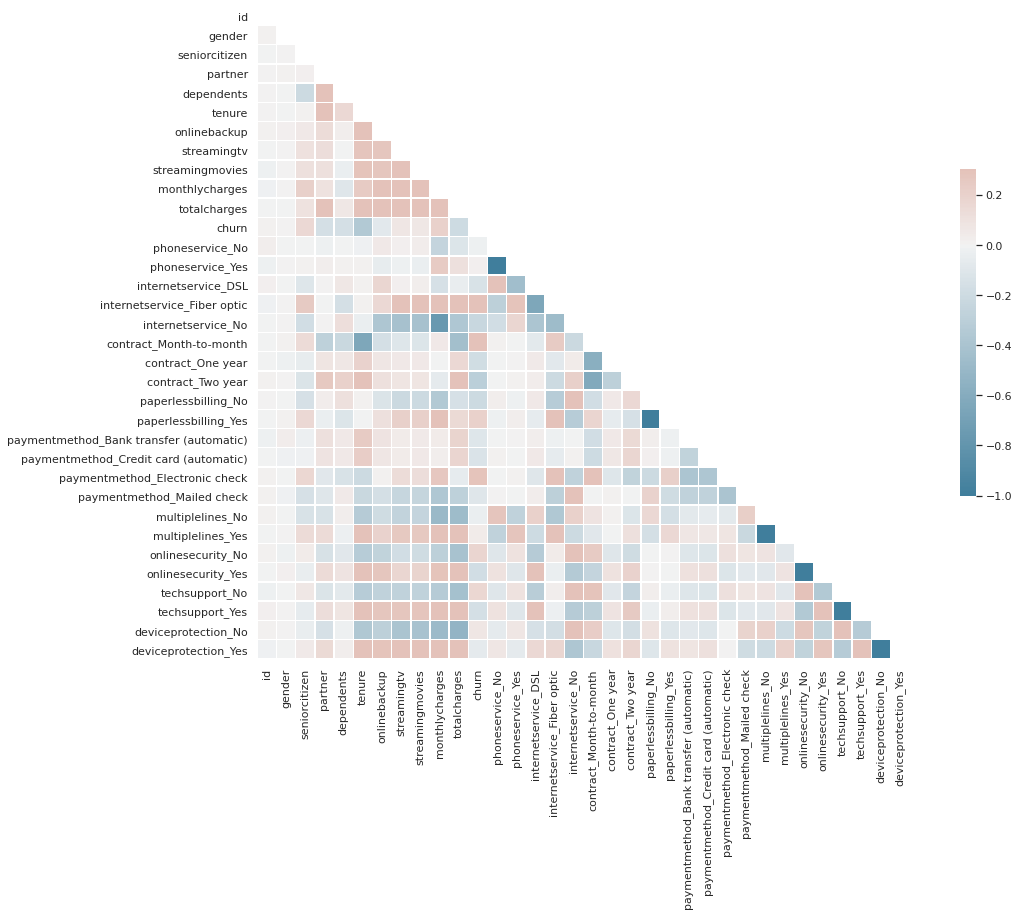

In [45]:
import seaborn as sns
from string import ascii_letters
import matplotlib.pyplot as plt

sns.set_theme(style = "white")

d = df_train_dumy

# Compute the correlation matrix
corr = d.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 12))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

###TESTE:carrerga o teste

In [46]:
url = 'https://raw.githubusercontent.com/jjefferson2006/DSWP_JJ_altera/main/test.csv'
df_churn_test = pd.read_csv(url)
df_churn_test

id  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0     5027    Male              0     Yes        Yes    23.0          Yes   
1     1733    Male              1     Yes        Yes    61.0          Yes   
2     5384    Male              0      No         No    36.0          Yes   
3     6554  Female              0     Yes        Yes    61.0           No   
4      364  Female              0      No         No    47.0          Yes   
...    ...     ...            ...     ...        ...     ...          ...   
1404  4897    Male              0      No        NaN    24.0          Yes   
1405  6940    Male              0      No         No    35.0          Yes   
1406   804  Female              0     Yes         No    46.0          Yes   
1407  1143    Male              1     Yes        Yes    11.0          Yes   
1408  5773    Male              0     Yes        Yes    69.0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
0                   No              No  No internet service   
1                  Yes     Fiber optic                   No   
2                  Yes     Fiber optic                   No   
3     No phone service             DSL                   No   
4                   No              No  No internet service   
...                ...             ...                  ...   
1404                No             DSL                   No   
1405                No     Fiber optic                  Yes   
1406                No             DSL                   No   
1407               Yes     Fiber optic                   No   
1408               Yes             DSL                   No   

             OnlineBackup     DeviceProtection          TechSupport  \
0     No internet service  No internet service  No internet service   
1                     Yes                   No                   No   
2                      No                   No                   No   
3                     Yes                  Yes                  Yes   
4     No internet service  No internet service  No internet service   
...                   ...                  ...                  ...   
1404                   No                  Yes                   No   
1405                   No                   No                  Yes   
1406                  Yes                   No                  Yes   
1407                   No                   No                   No   
1408                  Yes                  Yes                  Yes   

              StreamingTV      StreamingMovies        Contract  \
0     No internet service  No internet service        One year   
1                     Yes                  Yes        One year   
2                      No                  Yes  Month-to-month   
3                     Yes                  Yes        Two year   
4     No internet service  No internet service        Two year   
...                   ...                  ...             ...   
1404                   No                   No  Month-to-month   
1405                   No                  Yes        One year   
1406                  Yes                   No        Two year   
1407                   No                   No  Month-to-month   
1408                  Yes                  Yes        Two year   

     PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0                 Yes    Credit card (automatic)           20.00        445.3  
1                  No                        NaN           99.00       5969.3  
2                 Yes           Electronic check           84.75      3050.15  
3                 Yes  Bank transfer (automatic)           61.45      3751.15  
4                 Yes               Mailed check           20.55        945.7  
...               ...                        ...             ...          ...  
1404              Yes               Mailed check           49.70       1167.8  
1405              Yes           Electron

In [47]:
#Normalizar as colunas
df_churn_test.columns = [col.lower() for col in df_churn_test.columns]
df_churn_test.head()

id  gender  seniorcitizen partner dependents  tenure phoneservice  \
0  5027    Male              0     Yes        Yes    23.0          Yes   
1  1733    Male              1     Yes        Yes    61.0          Yes   
2  5384    Male              0      No         No    36.0          Yes   
3  6554  Female              0     Yes        Yes    61.0           No   
4   364  Female              0      No         No    47.0          Yes   

      multiplelines internetservice       onlinesecurity         onlinebackup  \
0                No              No  No internet service  No internet service   
1               Yes     Fiber optic                   No                  Yes   
2               Yes     Fiber optic                   No                   No   
3  No phone service             DSL                   No                  Yes   
4                No              No  No internet service  No internet service   

      deviceprotection          techsupport          streamingtv  \
0  No internet service  No internet service  No internet service   
1                   No                   No                  Yes   
2                   No                   No                   No   
3                  Yes                  Yes                  Yes   
4  No internet service  No internet service  No internet service   

       streamingmovies        contract paperlessbilling  \
0  No internet service        One year              Yes   
1                  Yes        One year               No   
2                  Yes  Month-to-month              Yes   
3                  Yes        Two year              Yes   
4  No internet service        Two year              Yes   

               paymentmethod  monthlycharges totalcharges  
0    Credit card (automatic)           20.00        445.3  
1                        NaN           99.00       5969.3  
2           Electronic check           84.75      3050.15  
3  Bank transfer (automatic)           61.45      3751.15  
4               Mailed check           20.55        945.7

In [48]:
df_churn_test.dtypes

id                    int64
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure              float64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges         object
dtype: object

In [49]:
df_churn_test.isna().sum()

id                    0
gender                0
seniorcitizen         0
partner               0
dependents           41
tenure              118
phoneservice          0
multiplelines         0
internetservice       0
onlinesecurity        0
onlinebackup          0
deviceprotection      0
techsupport           0
streamingtv           0
streamingmovies       0
contract              0
paperlessbilling      0
paymentmethod        30
monthlycharges        0
totalcharges          0
dtype: int64

In [50]:
df_churn_test.shape

(1409, 20)

#TESTE:tratamento do dependentes/ paymenthod /total / tenure

In [51]:
df_churn_test['dependents'].fillna('No', inplace=True)
df_churn_test['paymentmethod'].fillna('Electronic check', inplace=True)

In [52]:
df_churn_test['totalcharges'] = df_churn_test['totalcharges'].str.replace(',', '.')
df_churn_test['totalcharges'] = pd.to_numeric(df_churn_test['totalcharges'], errors= 'coerce')
df_churn_test[['totalcharges']].isna().sum()

totalcharges    3
dtype: int64

In [53]:
df_churn_test['tenure_esti']=round(df_churn_test['totalcharges']/df_churn_test['monthlycharges'],2)
df_churn_test['tenure_rou']=round(df_churn_test['tenure_esti'])
l_tot_ten = list(df_churn_test[df_churn_test['tenure'].isna()].index)
for i in l_tot_ten:
    df_churn_test['tenure'][i] = df_churn_test['tenure_rou'][i]


In [54]:
l_index_charg = list(df_churn_test[df_churn_test['totalcharges'].isna()].index)
l_index_charg

[313, 1063, 1297]

In [55]:
df_churn_test[['tenure','totalcharges']][313:314]

tenure  totalcharges
313     0.0           NaN

In [56]:
df_churn_test.drop(columns=['tenure_esti','tenure_rou'], inplace=True)

In [57]:
for i in l_index_charg:
    df_churn_test['totalcharges'][i] = 0.0

In [58]:
df_churn_test.isna().sum()

id                  0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
dtype: int64

###TESTE: poe  'no phone service' em no e no internet service no no

In [59]:
df_churn_test.onlinesecurity.replace(['No internet service'],['No'],inplace=True)
df_churn_test.multiplelines.replace(['No phone service'],['No'],inplace=True)
df_churn_test.onlinebackup.replace(['No internet service'],['No'],inplace=True)
df_churn_test.deviceprotection.replace(['No internet service'],['No'],inplace=True)
df_churn_test.techsupport.replace(['No internet service'],['No'],inplace=True)
df_churn_test.streamingtv.replace(['No internet service'],['No'],inplace=True)
df_churn_test.streamingmovies.replace(['No internet service'],['No'],inplace=True)

In [60]:
df_churn_test.head()

id  gender  seniorcitizen partner dependents  tenure phoneservice  \
0  5027    Male              0     Yes        Yes    23.0          Yes   
1  1733    Male              1     Yes        Yes    61.0          Yes   
2  5384    Male              0      No         No    36.0          Yes   
3  6554  Female              0     Yes        Yes    61.0           No   
4   364  Female              0      No         No    47.0          Yes   

  multiplelines internetservice onlinesecurity onlinebackup deviceprotection  \
0            No              No             No           No               No   
1           Yes     Fiber optic             No          Yes               No   
2           Yes     Fiber optic             No           No               No   
3            No             DSL             No          Yes              Yes   
4            No              No             No           No               No   

  techsupport streamingtv streamingmovies        contract paperlessbilling  \
0          No          No              No        One year              Yes   
1          No         Yes             Yes        One year               No   
2          No          No             Yes  Month-to-month              Yes   
3         Yes         Yes             Yes        Two year              Yes   
4          No          No              No        Two year              Yes   

               paymentmethod  monthlycharges  totalcharges  
0    Credit card (automatic)           20.00        445.30  
1           Electronic check           99.00       5969.30  
2           Electronic check           84.75       3050.15  
3  Bank transfer (automatic)           61.45       3751.15  
4               Mailed check           20.55        945.70

In [61]:
df_churn_test.gender.replace(['Female', 'Male'], [1, 0], inplace=True)
df_churn_test.partner.replace(['Yes', 'No'], [1, 0], inplace=True)
df_churn_test.dependents.replace(['Yes', 'No'], [1, 0], inplace=True)


In [62]:
#df_churn_test.multiplelines.replace(['No', 'Yes'], [0,1], inplace=True)
#df_churn_test.onlinesecurity.replace(['No', 'Yes'], [0,1], inplace=True) 
df_churn_test.onlinebackup.replace(['No', 'Yes'], [0,1], inplace=True)
#df_churn_test.deviceprotection.replace(['No', 'Yes'], [0,1], inplace=True)
#df_churn_test.techsupport.replace(['No', 'Yes'], [0,1], inplace=True)
df_churn_test.streamingtv.replace(['No', 'Yes'], [0,1], inplace=True)
df_churn_test.streamingmovies.replace(['No', 'Yes'], [0,1], inplace=True)

In [63]:
dummy_t=pd.get_dummies(df_churn_test[['phoneservice','internetservice','contract','paperlessbilling','paymentmethod','multiplelines', 'onlinesecurity', 'techsupport', 'deviceprotection']])
dummy_t

phoneservice_No  phoneservice_Yes  internetservice_DSL  \
0                   0                 1                    0   
1                   0                 1                    0   
2                   0                 1                    0   
3                   1                 0                    1   
4                   0                 1                    0   
...               ...               ...                  ...   
1404                0                 1                    1   
1405                0                 1                    0   
1406                0                 1                    1   
1407                0                 1                    0   
1408                0                 1                    1   

      internetservice_Fiber optic  internetservice_No  \
0                               0                   1   
1                               1                   0   
2                               1                   0   
3                               0                   0   
4                               0                   1   
...                           ...                 ...   
1404                            0                   0   
1405                            1                   0   
1406                            0                   0   
1407                            1                   0   
1408                            0                   0   

      contract_Month-to-month  contract_One year  contract_Two year  \
0                           0                  1                  0   
1                           0                  1                  0   
2                           1                  0                  0   
3                           0                  0                  1   
4                           0                  0                  1   
...                       ...                ...                ...   
1404                        1                  0                  0   
1405                        0                  1                  0   
1406                        0                  0                  1   
1407                        1                  0                  0   
1408                        0                  0                  1   

      paperlessbilling_No  paperlessbilling_Yes  \
0                       0                     1   
1                       1                     0   
2                       0                     1   
3                       0                     1   
4                       0                     1   
...                   ...                   ...   
1404                    0                     1   
1405                    0                     1   
1406                    0                     1   
1407                    0                     1   
1408                    0                     1   

      paymentmethod_Bank transfer (automatic)  \
0                                           0   
1                                           0   
2                                           0   
3                                           1   
4                                           0   
...                                       ...   
1404                                        0   
1405                                        0   
1406                                        0   
1407                                        0   
1408                                        1   

      paymentmethod_Credit card (automatic)  paymentmethod_Electronic check  \
0                                         1                               0   
1                                         0                               1   
2                                         0                               1   
3                                         0                               0   
4                                         0                               0   
...                    

In [64]:
df_test_dumy=pd.concat([df_churn_test,dummy_t],axis=1)
df_test_dumy

id  gender  seniorcitizen  partner  dependents  tenure phoneservice  \
0     5027       0              0        1           1    23.0          Yes   
1     1733       0              1        1           1    61.0          Yes   
2     5384       0              0        0           0    36.0          Yes   
3     6554       1              0        1           1    61.0           No   
4      364       1              0        0           0    47.0          Yes   
...    ...     ...            ...      ...         ...     ...          ...   
1404  4897       0              0        0           0    24.0          Yes   
1405  6940       0              0        0           0    35.0          Yes   
1406   804       1              0        1           0    46.0          Yes   
1407  1143       0              1        1           1    11.0          Yes   
1408  5773       0              0        1           1    69.0          Yes   

     multiplelines internetservice onlinesecurity  onlinebackup  \
0               No              No             No             0   
1              Yes     Fiber optic             No             1   
2              Yes     Fiber optic             No             0   
3               No             DSL             No             1   
4               No              No             No             0   
...            ...             ...            ...           ...   
1404            No             DSL             No             0   
1405            No     Fiber optic            Yes             0   
1406            No             DSL             No             1   
1407           Yes     Fiber optic             No             0   
1408           Yes             DSL             No             1   

     deviceprotection techsupport  streamingtv  streamingmovies  \
0                  No          No            0                0   
1                  No          No            1                1   
2                  No          No            0                1   
3                 Yes         Yes            1                1   
4                  No          No            0                0   
...               ...         ...          ...              ...   
1404              Yes          No            0                0   
1405               No         Yes            0                1   
1406               No         Yes            1                0   
1407               No          No            0                0   
1408              Yes         Yes            1                1   

            contract paperlessbilling              paymentmethod  \
0           One year              Yes    Credit card (automatic)   
1           One year               No           Electronic check   
2     Month-to-month              Yes           Electronic check   
3           Two year              Yes  Bank transfer (automatic)   
4           Two year              Yes               Mailed check   
...              ...              ...                        ...   
1404  Month-to-month              Yes               Mailed check   
1405        One year              Yes           Electronic check   
1406        Two year              Yes    Credit card (automatic)   
1407  Month-to-month              Yes    Credit card (automatic)   
1408        Two year              Yes  Bank transfer (automatic)   

      monthlycharges  totalcharges  phoneservice_No  phoneservice_Yes  \
0              20.00        445.30                0                 1   
1              99.00       5969.30                0                 1   
2              84.75       3050.15                0                 1   
3              61.45       3751.15                1                 0   
4              20.55        945.70                0                 1   
...              ...           ...              ...               ...   
1404           49.70       1167.80                0                 1   
1405           89.20       3251.30              

In [65]:
df_test_dumy.drop(columns=['phoneservice','internetservice','contract','paperlessbilling','paymentmethod','multiplelines', 'onlinesecurity', 'techsupport', 'deviceprotection'], inplace = True)

In [66]:
df_test_dumy.isna().sum()

id                                         0
gender                                     0
seniorcitizen                              0
partner                                    0
dependents                                 0
tenure                                     0
onlinebackup                               0
streamingtv                                0
streamingmovies                            0
monthlycharges                             0
totalcharges                               0
phoneservice_No                            0
phoneservice_Yes                           0
internetservice_DSL                        0
internetservice_Fiber optic                0
internetservice_No                         0
contract_Month-to-month                    0
contract_One year                          0
contract_Two year                          0
paperlessbilling_No                        0
paperlessbilling_Yes                       0
paymentmethod_Bank transfer (automatic)    0
paymentmet

In [67]:
df_test_dumy

id  gender  seniorcitizen  partner  dependents  tenure  onlinebackup  \
0     5027       0              0        1           1    23.0             0   
1     1733       0              1        1           1    61.0             1   
2     5384       0              0        0           0    36.0             0   
3     6554       1              0        1           1    61.0             1   
4      364       1              0        0           0    47.0             0   
...    ...     ...            ...      ...         ...     ...           ...   
1404  4897       0              0        0           0    24.0             0   
1405  6940       0              0        0           0    35.0             0   
1406   804       1              0        1           0    46.0             1   
1407  1143       0              1        1           1    11.0             0   
1408  5773       0              0        1           1    69.0             1   

      streamingtv  streamingmovies  monthlycharges  totalcharges  \
0               0                0           20.00        445.30   
1               1                1           99.00       5969.30   
2               0                1           84.75       3050.15   
3               1                1           61.45       3751.15   
4               0                0           20.55        945.70   
...           ...              ...             ...           ...   
1404            0                0           49.70       1167.80   
1405            0                1           89.20       3251.30   
1406            1                0           64.20       3009.50   
1407            0                0           75.20        775.30   
1408            1                1           81.95       5601.40   

      phoneservice_No  phoneservice_Yes  internetservice_DSL  \
0                   0                 1                    0   
1                   0                 1                    0   
2                   0                 1                    0   
3                   1                 0                    1   
4                   0                 1                    0   
...               ...               ...                  ...   
1404                0                 1                    1   
1405                0                 1                    0   
1406                0                 1                    1   
1407                0                 1                    0   
1408                0                 1                    1   

      internetservice_Fiber optic  internetservice_No  \
0                               0                   1   
1                               1                   0   
2                               1                   0   
3                               0                   0   
4                               0                   1   
...                           ...                 ...   
1404                            0                   0   
1405                            1                   0   
1406                            0                   0   
1407                            1                   0   
1408                            0                   0   

      contract_Month-to-month  contract_One year  contract_Two year  \
0                           0                  1                  0   
1                           0                  1                  0   
2                           1                  0                  0   
3                           0                  0                  1   
4                           0                  0                  1   
...                       ...                ...                ...   
1404                        1                  0                  0   
1405                        0                  1                  0   
1406                        0                  0                  1   
1407                        1                  0                  

In [ ]:
'''df_test_dumy.drop(columns=['id', 'gender', 'partner', 'dependents', 'tenure', 'multiplelines', 'onlinebackup',
                            'deviceprotection', 'techsupport', 'streamingtv', 'monthlycharges', 'totalcharges',
                            'internetservice_DSL', 'internetservice_No',
                            'contract_One year', 'contract_Two year',
                            'paymentmethod_Bank transfer (automatic)', 'paymentmethod_Credit card (automatic)', 'paymentmethod_Electronic check'], inplace=True)

In [68]:
df_test_dumy.head()

id  gender  seniorcitizen  partner  dependents  tenure  onlinebackup  \
0  5027       0              0        1           1    23.0             0   
1  1733       0              1        1           1    61.0             1   
2  5384       0              0        0           0    36.0             0   
3  6554       1              0        1           1    61.0             1   
4   364       1              0        0           0    47.0             0   

   streamingtv  streamingmovies  monthlycharges  totalcharges  \
0            0                0           20.00        445.30   
1            1                1           99.00       5969.30   
2            0                1           84.75       3050.15   
3            1                1           61.45       3751.15   
4            0                0           20.55        945.70   

   phoneservice_No  phoneservice_Yes  internetservice_DSL  \
0                0                 1                    0   
1                0                 1                    0   
2                0                 1                    0   
3                1                 0                    1   
4                0                 1                    0   

   internetservice_Fiber optic  internetservice_No  contract_Month-to-month  \
0                            0                   1                        0   
1                            1                   0                        0   
2                            1                   0                        1   
3                            0                   0                        0   
4                            0                   1                        0   

   contract_One year  contract_Two year  paperlessbilling_No  \
0                  1                  0                    0   
1                  1                  0                    1   
2                  0                  0                    0   
3                  0                  1                    0   
4                  0                  1                    0   

   paperlessbilling_Yes  paymentmethod_Bank transfer (automatic)  \
0                     1                                        0   
1                     0                                        0   
2                     1                                        0   
3                     1                                        1   
4                     1                                        0   

   paymentmethod_Credit card (automatic)  paymentmethod_Electronic check  \
0                                      1                               0   
1                                      0                               1   
2                                      0                               1   
3                                      0                               0   
4                                      0                               0   

   paymentmethod_Mailed check  multiplelines_No  multiplelines_Yes  \
0                           0                 1                  0   
1                           0                 0                  1   
2                           0                 0                  1   
3                           0                 1                  0   
4                           1                 1                  0   

   onlinesecurity_No  onlinesecurity_Yes  techsupport_No  techsupport_Yes  \
0                  1                   0               1                0   
1                  1                   0               1                0   
2                  1                   0               1                0   
3                  1                   0               0                1   
4                  1                   0               1                0   

   deviceprotection_No  deviceprotection_Yes  
0                    1                     0  
1                    1                     0  
2                    1           

###AUTO ML

In [69]:
df_train_dumy.columns

Index(['id', 'gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'onlinebackup', 'streamingtv', 'streamingmovies', 'monthlycharges',
       'totalcharges', 'churn', 'phoneservice_No', 'phoneservice_Yes',
       'internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No', 'contract_Month-to-month', 'contract_One year',
       'contract_Two year', 'paperlessbilling_No', 'paperlessbilling_Yes',
       'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check',
       'multiplelines_No', 'multiplelines_Yes', 'onlinesecurity_No',
       'onlinesecurity_Yes', 'techsupport_No', 'techsupport_Yes',
       'deviceprotection_No', 'deviceprotection_Yes'],
      dtype='object')

In [70]:
clf = setup(data = df_train_dumy,
            target = 'churn',
            session_id = 2214,
            normalize = True,
            transformation = True,
            ignore_low_variance = True,
            remove_multicollinearity = True, multicollinearity_threshold = 0.95,
            log_experiment = True,
            numeric_features = [ 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'onlinebackup', 'streamingtv', 'streamingmovies', 'monthlycharges',
       'totalcharges', 'phoneservice_No', 'phoneservice_Yes',
       'internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No', 'contract_Month-to-month', 'contract_One year',
       'contract_Two year', 'paperlessbilling_No', 'paperlessbilling_Yes',
       'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check',
       'multiplelines_No', 'multiplelines_Yes', 'onlinesecurity_No',
       'onlinesecurity_Yes', 'techsupport_No', 'techsupport_Yes',
       'deviceprotection_No', 'deviceprotection_Yes'], 
            #numeric_imputation = 'mean'
            #categorical_features = ['seniorcitizen', 'onlinesecurity', 'streamingmovies',
            #                        'phoneservice_No', 'phoneservice_Yes', 'internetservice_Fiber optic',
            #                        'contract_Month-to-month', 'paperlessbilling_No',
            #                        'paperlessbilling_Yes', 'paymentmethod_Mailed check'], # lista das variáveis categóricas
            profile = True,
            ignore_features = ['id', 'gender'],
            silent = False)

In [71]:
compare_models()

Model  Accuracy     AUC  Recall   Prec.  \
lr                    Logistic Regression    0.8090  0.8492  0.5447  0.6721   
lda          Linear Discriminant Analysis    0.8085  0.8441  0.5351  0.6752   
gbc          Gradient Boosting Classifier    0.8078  0.8516  0.5447  0.6706   
ridge                    Ridge Classifier    0.8055  0.0000  0.4910  0.6855   
lightgbm  Light Gradient Boosting Machine    0.8027  0.8394  0.5609  0.6488   
catboost              CatBoost Classifier    0.8024  0.8467  0.5322  0.6592   
ada                  Ada Boost Classifier    0.8012  0.8510  0.5476  0.6506   
rf               Random Forest Classifier    0.7974  0.8312  0.5063  0.6534   
xgboost         Extreme Gradient Boosting    0.7958  0.8278  0.5427  0.6350   
et                 Extra Trees Classifier    0.7844  0.8088  0.5139  0.6136   
svm                   SVM - Linear Kernel    0.7761  0.0000  0.5162  0.6004   
knn                K Neighbors Classifier    0.7705  0.7902  0.5332  0.5727   
nb                            Naive Bayes    0.7507  0.8374  0.7815  0.5197   
dt               Decision Tree Classifier    0.7363  0.6665  0.5131  0.5033   
qda       Quadratic Discriminant Analysis    0.6916  0.6123  0.4439  0.3623   

              F1   Kappa     MCC  TT (Sec)  
lr        0.6002  0.4770  0.4824     0.134  
lda       0.5954  0.4725  0.4790     0.033  
gbc       0.5990  0.4748  0.4805     0.479  
ridge     0.5701  0.4494  0.4609     0.022  
lightgbm  0.5996  0.4700  0.4735     0.128  
catboost  0.5869  0.4594  0.4652     3.227  
ada       0.5923  0.4625  0.4670     0.212  
rf        0.5678  0.4388  0.4464     0.706  
xgboost   0.5835  0.4498  0.4533     0.765  
et        0.5573  0.4166  0.4208     0.657  
svm       0.5392  0.3966  0.4060     0.043  
knn       0.5509  0.3973  0.3986     0.133  
nb        0.6239  0.4487  0.4700     0.022  
dt        0.5069  0.3273  0.3281     0.032  
qda       0.3716  0.1956  0.2079     0.026

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2214, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

###seed liberada final1
Model	Accuracy	AUC	Recall	Prec.	F1	Kappa	MCC	TT (Sec)
ada	Ada Boost Classifier	0.8146	0.8546	0.5790	0.6791	0.6238	0.5020	0.5057	0.215

gbc	Gradient Boosting Classifier	0.8128	0.8571	0.5733	0.6761	0.6196	0.4967	0.5003	0.481

lda	Linear Discriminant Analysis	0.8126	0.8508	0.5629	0.6785	0.6142	0.4921	0.4965	0.034

lr	Logistic Regression	0.8103	0.8555	0.5648	0.6701	0.6119	0.4879	0.4916	0.043

ridge	Ridge Classifier	0.8083	0.0000	0.5057	0.6899	0.5824	0.4622	0.4722	0.020

catboost	CatBoost Classifier	0.8042	0.8489	0.5448	0.6594	0.5958	0.4685	0.4726	3.349

In [ ]:
ada1 = create_model('ada')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8127  0.8713  0.5143  0.7013  0.5934  0.4754  0.4851
1       0.8228  0.8288  0.6095  0.6882  0.6465  0.5288  0.5305
2       0.8354  0.8787  0.6095  0.7273  0.6632  0.5554  0.5592
3       0.7716  0.8073  0.5143  0.5806  0.5455  0.3937  0.3950
4       0.8350  0.8662  0.6667  0.7000  0.6829  0.5715  0.5718
5       0.8325  0.8898  0.6286  0.7097  0.6667  0.5554  0.5572
6       0.7970  0.8425  0.5333  0.6437  0.5833  0.4507  0.4541
7       0.8223  0.8547  0.5333  0.7273  0.6154  0.5034  0.5136
8       0.8122  0.8619  0.6381  0.6505  0.6442  0.5167  0.5167
9       0.8046  0.8447  0.5429  0.6628  0.5969  0.4696  0.4736
Mean    0.8146  0.8546  0.5790  0.6791  0.6238  0.5020  0.5057
SD      0.0189  0.0233  0.0542  0.0432  0.0416  0.0525  0.0520

In [ ]:
tuned_ada1 = tune_model(ada1)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8101  0.8707  0.5238  0.6875  0.5946  0.4736  0.4810
1       0.8152  0.8299  0.6000  0.6702  0.6332  0.5102  0.5115
2       0.8177  0.8791  0.5905  0.6813  0.6327  0.5123  0.5146
3       0.7843  0.8148  0.5238  0.6111  0.5641  0.4219  0.4241
4       0.8452  0.8715  0.6952  0.7157  0.7053  0.6004  0.6005
5       0.8325  0.8894  0.6286  0.7097  0.6667  0.5554  0.5572
6       0.8020  0.8482  0.5619  0.6484  0.6020  0.4712  0.4733
7       0.8198  0.8513  0.5429  0.7125  0.6162  0.5013  0.5092
8       0.7970  0.8646  0.6000  0.6238  0.6117  0.4743  0.4744
9       0.8046  0.8454  0.5429  0.6628  0.5969  0.4696  0.4736
Mean    0.8128  0.8565  0.5810  0.6723  0.6223  0.4990  0.5019
SD      0.0166  0.0218  0.0509  0.0346  0.0380  0.0475  0.0468

In [ ]:
gbc1 = create_model('gbc')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8203  0.8788  0.5429  0.7125  0.6162  0.5016  0.5096
1       0.7975  0.8189  0.5524  0.6374  0.5918  0.4581  0.4601
2       0.8253  0.8656  0.6000  0.7000  0.6462  0.5311  0.5339
3       0.7843  0.8127  0.5048  0.6163  0.5550  0.4144  0.4180
4       0.8096  0.8855  0.6190  0.6500  0.6341  0.5056  0.5059
5       0.8401  0.8907  0.6286  0.7333  0.6769  0.5715  0.5745
6       0.7970  0.8375  0.5524  0.6374  0.5918  0.4576  0.4597
7       0.8198  0.8558  0.5333  0.7179  0.6120  0.4980  0.5073
8       0.8173  0.8681  0.6286  0.6667  0.6471  0.5239  0.5243
9       0.8173  0.8577  0.5714  0.6897  0.6250  0.5056  0.5095
Mean    0.8128  0.8571  0.5733  0.6761  0.6196  0.4967  0.5003
SD      0.0154  0.0253  0.0413  0.0380  0.0328  0.0418  0.0418

In [ ]:
tuned_gbc1 = tune_model(gbc1)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8152  0.8638  0.5619  0.6860  0.6178  0.4975  0.5018
1       0.7949  0.8134  0.5524  0.6304  0.5888  0.4530  0.4548
2       0.8127  0.8633  0.5714  0.6742  0.6186  0.4955  0.4985
3       0.7792  0.8104  0.5048  0.6023  0.5492  0.4045  0.4073
4       0.8274  0.8873  0.6190  0.6989  0.6566  0.5419  0.5437
5       0.8173  0.8791  0.5905  0.6813  0.6327  0.5119  0.5142
6       0.7843  0.8426  0.5429  0.6064  0.5729  0.4291  0.4303
7       0.8223  0.8558  0.5714  0.7059  0.6316  0.5162  0.5212
8       0.7995  0.8661  0.6000  0.6300  0.6146  0.4792  0.4795
9       0.7970  0.8409  0.5238  0.6471  0.5789  0.4471  0.4514
Mean    0.8050  0.8523  0.5638  0.6562  0.6062  0.4776  0.4803
SD      0.0155  0.0243  0.0329  0.0360  0.0310  0.0409  0.0412

In [ ]:
lda1 = create_model('lda')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8051  0.8589  0.5143  0.6750  0.5838  0.4595  0.4668
1       0.8076  0.8097  0.5333  0.6747  0.5957  0.4718  0.4774
2       0.8278  0.8661  0.6095  0.7033  0.6531  0.5394  0.5418
3       0.7843  0.8079  0.4952  0.6190  0.5503  0.4107  0.4151
4       0.8299  0.8739  0.6571  0.6900  0.6732  0.5583  0.5586
5       0.8274  0.8927  0.6381  0.6907  0.6634  0.5476  0.5483
6       0.7995  0.8392  0.5143  0.6585  0.5775  0.4487  0.4546
7       0.8223  0.8429  0.5238  0.7333  0.6111  0.5001  0.5120
8       0.8046  0.8603  0.5524  0.6591  0.6010  0.4730  0.4762
9       0.8173  0.8560  0.5905  0.6813  0.6327  0.5119  0.5142
Mean    0.8126  0.8508  0.5629  0.6785  0.6142  0.4921  0.4965
SD      0.0141  0.0254  0.0541  0.0287  0.0382  0.0453  0.0438

In [ ]:
tuned_lda1 = tune_model(lda1)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8101  0.8595  0.5333  0.6829  0.5989  0.4770  0.4833
1       0.8051  0.8107  0.5429  0.6628  0.5969  0.4700  0.4741
2       0.8203  0.8648  0.6095  0.6809  0.6432  0.5236  0.5250
3       0.7843  0.8088  0.4952  0.6190  0.5503  0.4107  0.4151
4       0.8274  0.8765  0.6571  0.6832  0.6699  0.5531  0.5533
5       0.8325  0.8926  0.6476  0.7010  0.6733  0.5609  0.5617
6       0.8071  0.8424  0.5429  0.6706  0.6000  0.4748  0.4794
7       0.8299  0.8466  0.5524  0.7436  0.6339  0.5263  0.5361
8       0.8071  0.8618  0.5714  0.6593  0.6122  0.4847  0.4869
9       0.8173  0.8554  0.5905  0.6813  0.6327  0.5119  0.5142
Mean    0.8141  0.8519  0.5743  0.6785  0.6211  0.4993  0.5029
SD      0.0138  0.0250  0.0491  0.0300  0.0354  0.0427  0.0418

In [ ]:
lr1 = create_model('lr')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8051  0.8669  0.5143  0.6750  0.5838  0.4595  0.4668
1       0.8051  0.8124  0.5429  0.6628  0.5969  0.4700  0.4741
2       0.8278  0.8651  0.6190  0.6989  0.6566  0.5423  0.5440
3       0.7589  0.8122  0.4381  0.5610  0.4920  0.3370  0.3415
4       0.8249  0.8789  0.6476  0.6800  0.6634  0.5452  0.5455
5       0.8426  0.8953  0.6762  0.7172  0.6961  0.5900  0.5905
6       0.8020  0.8483  0.5524  0.6517  0.5979  0.4678  0.4706
7       0.8299  0.8577  0.5524  0.7436  0.6339  0.5263  0.5361
8       0.8020  0.8597  0.5619  0.6484  0.6020  0.4712  0.4733
9       0.8046  0.8586  0.5429  0.6628  0.5969  0.4696  0.4736
Mean    0.8103  0.8555  0.5648  0.6701  0.6119  0.4879  0.4916
SD      0.0220  0.0248  0.0649  0.0463  0.0530  0.0656  0.0648

In [ ]:
tuned_lr1 = tune_model(lr1)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8051  0.8673  0.5143  0.6750  0.5838  0.4595  0.4668
1       0.8076  0.8126  0.5429  0.6706  0.6000  0.4752  0.4798
2       0.8278  0.8652  0.6190  0.6989  0.6566  0.5423  0.5440
3       0.7614  0.8124  0.4476  0.5663  0.5000  0.3461  0.3503
4       0.8274  0.8794  0.6571  0.6832  0.6699  0.5531  0.5533
5       0.8401  0.8951  0.6667  0.7143  0.6897  0.5821  0.5828
6       0.8020  0.8484  0.5524  0.6517  0.5979  0.4678  0.4706
7       0.8249  0.8572  0.5429  0.7308  0.6230  0.5121  0.5217
8       0.8020  0.8601  0.5619  0.6484  0.6020  0.4712  0.4733
9       0.8046  0.8588  0.5429  0.6628  0.5969  0.4696  0.4736
Mean    0.8103  0.8556  0.5648  0.6702  0.6120  0.4879  0.4916
SD      0.0207  0.0248  0.0630  0.0428  0.0505  0.0623  0.0613

In [ ]:
bag_free = ensemble_model(ada1)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8228  0.8665  0.5810  0.7011  0.6354  0.5197  0.5237
1       0.8152  0.8233  0.5905  0.6739  0.6294  0.5071  0.5090
2       0.8101  0.8715  0.5619  0.6705  0.6114  0.4871  0.4904
3       0.7741  0.8081  0.4952  0.5909  0.5389  0.3908  0.3935
4       0.8426  0.8766  0.6857  0.7129  0.6990  0.5926  0.5928
5       0.8401  0.8878  0.6476  0.7234  0.6834  0.5769  0.5785
6       0.7995  0.8435  0.5524  0.6444  0.5949  0.4627  0.4651
7       0.8299  0.8548  0.5524  0.7436  0.6339  0.5263  0.5361
8       0.8173  0.8619  0.6476  0.6602  0.6538  0.5297  0.5298
9       0.8122  0.8508  0.5524  0.6824  0.6105  0.4886  0.4933
Mean    0.8164  0.8545  0.5867  0.6803  0.6291  0.5081  0.5112
SD      0.0190  0.0231  0.0546  0.0415  0.0430  0.0543  0.0539

In [ ]:
bag_free_gbc = ensemble_model(gbc1)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8127  0.8750  0.5143  0.7013  0.5934  0.4754  0.4851
1       0.8051  0.8238  0.5524  0.6591  0.6010  0.4734  0.4766
2       0.8304  0.8679  0.5810  0.7262  0.6455  0.5358  0.5416
3       0.7766  0.8106  0.4667  0.6049  0.5269  0.3839  0.3894
4       0.8350  0.8866  0.6381  0.7128  0.6734  0.5635  0.5650
5       0.8426  0.8901  0.6476  0.7312  0.6869  0.5823  0.5842
6       0.7893  0.8388  0.5333  0.6222  0.5744  0.4355  0.4378
7       0.8173  0.8594  0.5333  0.7089  0.6087  0.4926  0.5011
8       0.8147  0.8737  0.6381  0.6569  0.6473  0.5217  0.5218
9       0.8173  0.8593  0.5905  0.6813  0.6327  0.5119  0.5142
Mean    0.8141  0.8585  0.5695  0.6805  0.6190  0.4976  0.5017
SD      0.0191  0.0250  0.0571  0.0413  0.0456  0.0563  0.0553

In [ ]:
bag_free_lda1 = ensemble_model(lda1)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8076  0.8586  0.5238  0.6790  0.5914  0.4683  0.4750
1       0.8076  0.8098  0.5333  0.6747  0.5957  0.4718  0.4774
2       0.8253  0.8641  0.6190  0.6915  0.6533  0.5370  0.5385
3       0.7766  0.8056  0.4571  0.6076  0.5217  0.3798  0.3864
4       0.8249  0.8728  0.6286  0.6875  0.6567  0.5395  0.5405
5       0.8299  0.8919  0.6476  0.6939  0.6700  0.5556  0.5562
6       0.8020  0.8397  0.5238  0.6627  0.5851  0.4574  0.4629
7       0.8249  0.8445  0.5333  0.7368  0.6188  0.5089  0.5201
8       0.7995  0.8610  0.5429  0.6477  0.5907  0.4593  0.4624
9       0.8122  0.8559  0.5810  0.6703  0.6224  0.4983  0.5006
Mean    0.8111  0.8504  0.5590  0.6752  0.6106  0.4876  0.4920
SD      0.0154  0.0253  0.0559  0.0318  0.0415  0.0493  0.0478

In [ ]:
bag_free_lr1 = ensemble_model(lr1)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8051  0.8684  0.5143  0.6750  0.5838  0.4595  0.4668
1       0.8025  0.8123  0.5238  0.6627  0.5851  0.4579  0.4633
2       0.8228  0.8629  0.6190  0.6842  0.6500  0.5318  0.5329
3       0.7614  0.8098  0.4381  0.5679  0.4946  0.3419  0.3468
4       0.8299  0.8784  0.6476  0.6939  0.6700  0.5556  0.5562
5       0.8376  0.8936  0.6762  0.7030  0.6893  0.5794  0.5796
6       0.8020  0.8483  0.5524  0.6517  0.5979  0.4678  0.4706
7       0.8350  0.8584  0.5619  0.7564  0.6448  0.5404  0.5505
8       0.7919  0.8612  0.5524  0.6237  0.5859  0.4476  0.4490
9       0.8096  0.8585  0.5619  0.6705  0.6114  0.4866  0.4900
Mean    0.8098  0.8552  0.5648  0.6689  0.6113  0.4868  0.4906
SD      0.0219  0.0250  0.0654  0.0472  0.0529  0.0653  0.0646

In [ ]:
#desempenho no Kaggle 0.79261 horrivel
blender_h_free_bag = blend_models(estimator_list=[bag_free, bag_free_gbc, bag_free_lda1, bag_free_lr1], method ='hard')

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8025  0.0  0.4762  0.6849  0.5618  0.4396  0.4517
1       0.8177  0.0  0.5333  0.7089  0.6087  0.4930  0.5014
2       0.8278  0.0  0.5810  0.7176  0.6421  0.5304  0.5356
3       0.7665  0.0  0.4095  0.5890  0.4831  0.3386  0.3479
4       0.8350  0.0  0.6286  0.7174  0.6701  0.5607  0.5629
5       0.8503  0.0  0.6381  0.7614  0.6943  0.5962  0.6002
6       0.7970  0.0  0.4952  0.6582  0.5652  0.4362  0.4437
7       0.8274  0.0  0.5143  0.7606  0.6136  0.5078  0.5239
8       0.7995  0.0  0.5429  0.6477  0.5907  0.4593  0.4624
9       0.8096  0.0  0.5238  0.6875  0.5946  0.4732  0.4806
Mean    0.8133  0.0  0.5343  0.6933  0.6024  0.4835  0.4910
SD      0.0225  0.0  0.0655  0.0499  0.0568  0.0688  0.0674

In [ ]:
#desempenho no Kaggle 0.79261(com os tuneds) - 0.78693 (horrível)
blender_h_free2 = blend_models(estimator_list=[ada1, gbc1, lda1, lr1], method ='hard')

###seed liberad final 1

###**melhor resposta**

In [72]:
gbc = create_model('gbc')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7848  0.8273  0.4571  0.6316  0.5304  0.3954  0.4041
1       0.7975  0.8517  0.4476  0.6812  0.5402  0.4174  0.4325
2       0.7823  0.8268  0.5905  0.5905  0.5905  0.4422  0.4422
3       0.8198  0.8554  0.5577  0.6988  0.6203  0.5041  0.5096
4       0.7944  0.8432  0.5673  0.6211  0.5930  0.4558  0.4567
5       0.8249  0.8483  0.5385  0.7273  0.6188  0.5084  0.5180
6       0.8350  0.8681  0.6538  0.7010  0.6766  0.5661  0.5667
7       0.7868  0.8306  0.5192  0.6136  0.5625  0.4229  0.4254
8       0.8249  0.8743  0.5577  0.7160  0.6270  0.5149  0.5218
9       0.8274  0.8906  0.5577  0.7250  0.6304  0.5203  0.5280
Mean    0.8078  0.8516  0.5447  0.6706  0.5990  0.4748  0.4805
SD      0.0194  0.0201  0.0573  0.0487  0.0427  0.0526  0.0518

In [73]:
tuned_gbc = tune_model(gbc)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7823  0.8315  0.4762  0.6173  0.5376  0.3983  0.4041
1       0.8025  0.8520  0.4571  0.6957  0.5517  0.4320  0.4476
2       0.7949  0.8412  0.6190  0.6132  0.6161  0.4762  0.4762
3       0.8299  0.8555  0.5962  0.7126  0.6492  0.5382  0.5419
4       0.7944  0.8551  0.5865  0.6162  0.6010  0.4626  0.4629
5       0.8122  0.8500  0.5481  0.6786  0.6064  0.4849  0.4896
6       0.8223  0.8639  0.6250  0.6771  0.6500  0.5312  0.5320
7       0.7944  0.8254  0.5577  0.6237  0.5888  0.4523  0.4536
8       0.8274  0.8735  0.5577  0.7250  0.6304  0.5203  0.5280
9       0.8249  0.8869  0.5769  0.7059  0.6349  0.5213  0.5258
Mean    0.8085  0.8535  0.5600  0.6665  0.6066  0.4817  0.4862
SD      0.0161  0.0175  0.0527  0.0422  0.0364  0.0440  0.0430

In [74]:
evaluate_model(tuned_gbc)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [75]:
lr = create_model('lr')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7924  0.8290  0.4762  0.6494  0.5495  0.4187  0.4272
1       0.7949  0.8500  0.4571  0.6667  0.5424  0.4161  0.4284
2       0.7975  0.8386  0.5619  0.6344  0.5960  0.4615  0.4630
3       0.8198  0.8649  0.5769  0.6897  0.6283  0.5106  0.5141
4       0.8020  0.8438  0.5865  0.6354  0.6100  0.4776  0.4783
5       0.8147  0.8412  0.5096  0.7067  0.5922  0.4763  0.4870
6       0.8325  0.8649  0.6538  0.6939  0.6733  0.5608  0.5612
7       0.8020  0.8158  0.5288  0.6548  0.5851  0.4570  0.4615
8       0.8147  0.8588  0.5385  0.6914  0.6054  0.4868  0.4933
9       0.8198  0.8847  0.5577  0.6988  0.6203  0.5041  0.5096
Mean    0.8090  0.8492  0.5447  0.6721  0.6002  0.4770  0.4824
SD      0.0125  0.0189  0.0539  0.0258  0.0359  0.0409  0.0386

In [76]:
tuned_lr = tune_model(lr)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7949  0.8293  0.4952  0.6500  0.5622  0.4315  0.4383
1       0.8000  0.8497  0.4762  0.6757  0.5587  0.4343  0.4454
2       0.8000  0.8374  0.5619  0.6413  0.5990  0.4665  0.4683
3       0.8198  0.8649  0.5769  0.6897  0.6283  0.5106  0.5141
4       0.8020  0.8438  0.5962  0.6327  0.6139  0.4809  0.4813
5       0.8147  0.8413  0.5096  0.7067  0.5922  0.4763  0.4870
6       0.8350  0.8655  0.6635  0.6970  0.6798  0.5688  0.5691
7       0.8046  0.8164  0.5385  0.6588  0.5926  0.4657  0.4698
8       0.8122  0.8591  0.5385  0.6829  0.6022  0.4815  0.4873
9       0.8198  0.8851  0.5577  0.6988  0.6203  0.5041  0.5096
Mean    0.8103  0.8492  0.5514  0.6733  0.6049  0.4820  0.4870
SD      0.0117  0.0190  0.0512  0.0247  0.0329  0.0377  0.0357

In [77]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [78]:
rid = create_model('ridge')

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7797  0.0  0.4095  0.6324  0.4971  0.3643  0.3784
1       0.7975  0.0  0.4286  0.6923  0.5294  0.4093  0.4285
2       0.7924  0.0  0.5333  0.6292  0.5773  0.4410  0.4436
3       0.8249  0.0  0.5192  0.7397  0.6102  0.5017  0.5147
4       0.7970  0.0  0.5096  0.6463  0.5699  0.4394  0.4447
5       0.8096  0.0  0.4519  0.7231  0.5562  0.4431  0.4630
6       0.8376  0.0  0.6346  0.7174  0.6735  0.5659  0.5678
7       0.7944  0.0  0.4519  0.6620  0.5371  0.4110  0.4234
8       0.8096  0.0  0.4712  0.7101  0.5665  0.4508  0.4664
9       0.8122  0.0  0.5000  0.7027  0.5843  0.4674  0.4787
Mean    0.8055  0.0  0.4910  0.6855  0.5701  0.4494  0.4609
SD      0.0161  0.0  0.0613  0.0379  0.0456  0.0521  0.0495

In [79]:
tuned_rid = tune_model(rid)

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7823  0.0  0.4095  0.6418  0.5000  0.3694  0.3846
1       0.7949  0.0  0.4190  0.6875  0.5207  0.3999  0.4197
2       0.7924  0.0  0.5333  0.6292  0.5773  0.4410  0.4436
3       0.8223  0.0  0.5096  0.7361  0.6023  0.4927  0.5065
4       0.7970  0.0  0.5096  0.6463  0.5699  0.4394  0.4447
5       0.8122  0.0  0.4615  0.7273  0.5647  0.4525  0.4715
6       0.8401  0.0  0.6346  0.7253  0.6769  0.5713  0.5736
7       0.7919  0.0  0.4519  0.6528  0.5341  0.4058  0.4171
8       0.8173  0.0  0.5000  0.7222  0.5909  0.4782  0.4916
9       0.8122  0.0  0.5000  0.7027  0.5843  0.4674  0.4787
Mean    0.8063  0.0  0.4929  0.6871  0.5721  0.4518  0.4632
SD      0.0167  0.0  0.0612  0.0390  0.0467  0.0536  0.0511

In [80]:
evaluate_model(tuned_rid)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [81]:
lda = create_model('lda')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7772  0.8237  0.4286  0.6164  0.5056  0.3678  0.3779
1       0.8025  0.8412  0.4762  0.6849  0.5618  0.4396  0.4517
2       0.7899  0.8356  0.5619  0.6146  0.5871  0.4465  0.4473
3       0.8198  0.8657  0.5385  0.7089  0.6120  0.4975  0.5055
4       0.7893  0.8362  0.5288  0.6180  0.5699  0.4316  0.4339
5       0.8223  0.8289  0.5096  0.7361  0.6023  0.4927  0.5065
6       0.8376  0.8645  0.6635  0.7041  0.6832  0.5741  0.5745
7       0.7944  0.8072  0.5096  0.6386  0.5668  0.4343  0.4390
8       0.8223  0.8551  0.5481  0.7125  0.6196  0.5062  0.5136
9       0.8299  0.8833  0.5865  0.7176  0.6455  0.5351  0.5398
Mean    0.8085  0.8441  0.5351  0.6752  0.5954  0.4725  0.4790
SD      0.0193  0.0217  0.0601  0.0455  0.0467  0.0568  0.0558

In [82]:
tuned_lda = tune_model(lda)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7797  0.8241  0.4571  0.6154  0.5246  0.3853  0.3925
1       0.8000  0.8419  0.4952  0.6667  0.5683  0.4418  0.4501
2       0.7949  0.8350  0.5810  0.6224  0.6010  0.4632  0.4637
3       0.8299  0.8653  0.5769  0.7229  0.6417  0.5321  0.5379
4       0.7919  0.8378  0.5385  0.6222  0.5773  0.4402  0.4422
5       0.8173  0.8322  0.5288  0.7051  0.6044  0.4887  0.4973
6       0.8401  0.8649  0.6731  0.7071  0.6897  0.5821  0.5824
7       0.7970  0.8096  0.5192  0.6429  0.5745  0.4431  0.4475
8       0.8198  0.8571  0.5577  0.6988  0.6203  0.5041  0.5096
9       0.8325  0.8837  0.5962  0.7209  0.6526  0.5436  0.5478
Mean    0.8103  0.8452  0.5524  0.6724  0.6054  0.4824  0.4871
SD      0.0192  0.0211  0.0567  0.0413  0.0453  0.0561  0.0551

In [83]:
evaluate_model(tuned_lda)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [ ]:
blender_s = blend_models(estimator_list=[tuned_lr, tuned_lda, tuned_gbc], method ='soft')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7899  0.8279  0.4571  0.6486  0.5363  0.4057  0.4161
1       0.7949  0.8535  0.4667  0.6622  0.5475  0.4200  0.4308
2       0.7949  0.8390  0.5619  0.6277  0.5930  0.4565  0.4577
3       0.8274  0.8660  0.5673  0.7195  0.6344  0.5235  0.5298
4       0.8071  0.8453  0.5865  0.6489  0.6162  0.4878  0.4889
5       0.8223  0.8447  0.5192  0.7297  0.6067  0.4962  0.5082
6       0.8350  0.8668  0.6538  0.7010  0.6766  0.5661  0.5667
7       0.8020  0.8225  0.5481  0.6477  0.5938  0.4641  0.4669
8       0.8223  0.8673  0.5577  0.7073  0.6237  0.5095  0.5157
9       0.8249  0.8869  0.5769  0.7059  0.6349  0.5213  0.5258
Mean    0.8121  0.8520  0.5495  0.6799  0.6063  0.4851  0.4907
SD      0.0153  0.0190  0.0546  0.0346  0.0396  0.0468  0.0450

In [ ]:
blender_s_h = blend_models(estimator_list=[tuned_lr, tuned_lda, tuned_gbc], method ='hard')

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7899  0.0  0.4762  0.6410  0.5464  0.4136  0.4213
1       0.8025  0.0  0.4857  0.6800  0.5667  0.4434  0.4539
2       0.8000  0.0  0.5714  0.6383  0.6030  0.4699  0.4712
3       0.8223  0.0  0.5769  0.6977  0.6316  0.5159  0.5199
4       0.8046  0.0  0.5865  0.6421  0.6131  0.4827  0.4836
5       0.8147  0.0  0.5192  0.7013  0.5967  0.4799  0.4890
6       0.8376  0.0  0.6538  0.7083  0.6800  0.5714  0.5722
7       0.8071  0.0  0.5481  0.6628  0.6000  0.4744  0.4781
8       0.8223  0.0  0.5577  0.7073  0.6237  0.5095  0.5157
9       0.8274  0.0  0.5865  0.7093  0.6421  0.5297  0.5339
Mean    0.8128  0.0  0.5562  0.6788  0.6103  0.4890  0.4939
SD      0.0138  0.0  0.0498  0.0285  0.0358  0.0425  0.0408

In [ ]:
bag_tu_lr = ensemble_model(tuned_lr, n_estimators=260)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7949  0.8291  0.4857  0.6538  0.5574  0.4277  0.4357
1       0.8000  0.8496  0.4857  0.6711  0.5635  0.4381  0.4477
2       0.8000  0.8372  0.5619  0.6413  0.5990  0.4665  0.4683
3       0.8198  0.8649  0.5769  0.6897  0.6283  0.5106  0.5141
4       0.8020  0.8433  0.5962  0.6327  0.6139  0.4809  0.4813
5       0.8096  0.8412  0.4904  0.6986  0.5763  0.4583  0.4703
6       0.8350  0.8652  0.6635  0.6970  0.6798  0.5688  0.5691
7       0.8046  0.8160  0.5481  0.6552  0.5969  0.4692  0.4725
8       0.8071  0.8593  0.5288  0.6707  0.5914  0.4675  0.4731
9       0.8198  0.8850  0.5577  0.6988  0.6203  0.5041  0.5096
Mean    0.8093  0.8491  0.5495  0.6709  0.6027  0.4792  0.4842
SD      0.0116  0.0191  0.0531  0.0234  0.0339  0.0385  0.0363

In [ ]:
bag_tu_rid = ensemble_model(tuned_rid, n_estimators=260)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7797  0.7238  0.4000  0.6364  0.4912  0.3599  0.3757
1       0.7975  0.7378  0.4286  0.6923  0.5294  0.4093  0.4285
2       0.7924  0.7637  0.5333  0.6292  0.5773  0.4410  0.4436
3       0.8249  0.7822  0.5192  0.7397  0.6102  0.5017  0.5147
4       0.7970  0.7679  0.5096  0.6463  0.5699  0.4394  0.4447
5       0.8147  0.7542  0.4615  0.7385  0.5680  0.4580  0.4785
6       0.8376  0.7911  0.6346  0.7174  0.6735  0.5659  0.5678
7       0.7919  0.7521  0.4519  0.6528  0.5341  0.4058  0.4171
8       0.8173  0.7643  0.5000  0.7222  0.5909  0.4782  0.4916
9       0.8122  0.7951  0.5000  0.7027  0.5843  0.4674  0.4787
Mean    0.8065  0.7632  0.4939  0.6878  0.5729  0.4527  0.4641
SD      0.0168  0.0214  0.0618  0.0407  0.0470  0.0540  0.0516

In [ ]:
bag_tu_gbc = ensemble_model(tuned_gbc, n_estimators=260)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7848  0.8294  0.4381  0.6389  0.5198  0.3873  0.3987
1       0.7949  0.8562  0.4381  0.6765  0.5318  0.4081  0.4239
2       0.7949  0.8394  0.5905  0.6200  0.6049  0.4665  0.4668
3       0.8223  0.8617  0.5481  0.7125  0.6196  0.5062  0.5136
4       0.8071  0.8486  0.5769  0.6522  0.6122  0.4845  0.4861
5       0.8071  0.8496  0.4712  0.7000  0.5632  0.4454  0.4598
6       0.8274  0.8664  0.6250  0.6915  0.6566  0.5417  0.5429
7       0.8071  0.8309  0.5577  0.6591  0.6042  0.4778  0.4807
8       0.8198  0.8756  0.5096  0.7260  0.5989  0.4872  0.4999
9       0.8299  0.8852  0.5769  0.7229  0.6417  0.5321  0.5379
Mean    0.8095  0.8543  0.5332  0.6800  0.5953  0.4737  0.4810
SD      0.0144  0.0175  0.0623  0.0347  0.0421  0.0469  0.0438

In [ ]:
bag_tu_lda = ensemble_model(tuned_lda, n_estimators=260)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7747  0.8239  0.4381  0.6053  0.5083  0.3670  0.3750
1       0.7975  0.8419  0.4857  0.6623  0.5604  0.4329  0.4417
2       0.7949  0.8349  0.5810  0.6224  0.6010  0.4632  0.4637
3       0.8299  0.8654  0.5769  0.7229  0.6417  0.5321  0.5379
4       0.7944  0.8379  0.5481  0.6264  0.5846  0.4488  0.4506
5       0.8173  0.8322  0.5288  0.7051  0.6044  0.4887  0.4973
6       0.8401  0.8650  0.6731  0.7071  0.6897  0.5821  0.5824
7       0.7995  0.8090  0.5288  0.6471  0.5820  0.4519  0.4559
8       0.8198  0.8572  0.5577  0.6988  0.6203  0.5041  0.5096
9       0.8299  0.8836  0.5962  0.7126  0.6492  0.5382  0.5419
Mean    0.8098  0.8451  0.5514  0.6710  0.6042  0.4809  0.4856
SD      0.0196  0.0213  0.0605  0.0412  0.0480  0.0585  0.0572

In [ ]:
#desempenho kaggle 0.80113
blender_h_bag = blend_models(estimator_list=[bag_tu_lr, bag_tu_gbc, bag_tu_lda, bag_tu_rid], method ='hard')

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7797  0.0  0.4095  0.6324  0.4971  0.3643  0.3784
1       0.7949  0.0  0.4476  0.6714  0.5371  0.4121  0.4261
2       0.8000  0.0  0.5619  0.6413  0.5990  0.4665  0.4683
3       0.8299  0.0  0.5385  0.7467  0.6257  0.5194  0.5310
4       0.8020  0.0  0.5481  0.6477  0.5938  0.4641  0.4669
5       0.8147  0.0  0.4615  0.7385  0.5680  0.4580  0.4785
6       0.8325  0.0  0.6442  0.6979  0.6700  0.5580  0.5588
7       0.8046  0.0  0.5096  0.6709  0.5792  0.4550  0.4623
8       0.8198  0.0  0.5192  0.7200  0.6034  0.4907  0.5017
9       0.8173  0.0  0.5192  0.7105  0.6000  0.4853  0.4953
Mean    0.8095  0.0  0.5159  0.6877  0.5873  0.4673  0.4767
SD      0.0155  0.0  0.0625  0.0388  0.0447  0.0507  0.0482

In [84]:
#desempenho no Kaggle 0.80113 - com o dummy adiconando o device protection
blender_h = blend_models(estimator_list=[tuned_lr, tuned_lda, tuned_gbc, tuned_rid], method ='hard')

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7848  0.0  0.4476  0.6351  0.5251  0.3914  0.4014
1       0.7924  0.0  0.4286  0.6716  0.5233  0.3987  0.4152
2       0.8000  0.0  0.5619  0.6413  0.5990  0.4665  0.4683
3       0.8249  0.0  0.5385  0.7273  0.6188  0.5084  0.5180
4       0.8046  0.0  0.5385  0.6588  0.5926  0.4657  0.4698
5       0.8147  0.0  0.4904  0.7183  0.5829  0.4692  0.4833
6       0.8350  0.0  0.6346  0.7097  0.6701  0.5605  0.5621
7       0.7995  0.0  0.5000  0.6582  0.5683  0.4409  0.4480
8       0.8223  0.0  0.5288  0.7237  0.6111  0.4996  0.5099
9       0.8173  0.0  0.5288  0.7051  0.6044  0.4887  0.4973
Mean    0.8095  0.0  0.5198  0.6849  0.5895  0.4690  0.4773
SD      0.0150  0.0  0.0553  0.0337  0.0414  0.0480  0.0458

In [ ]:
#nota kaggle 0.80113
blender_2 = blend_models(estimator_list=[tuned_lr, tuned_gbc], method ='hard')

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7975  0.0  0.4476  0.6812  0.5402  0.4174  0.4325
1       0.8025  0.0  0.4190  0.7213  0.5301  0.4160  0.4406
2       0.7899  0.0  0.5143  0.6279  0.5654  0.4287  0.4324
3       0.8325  0.0  0.5385  0.7568  0.6292  0.5250  0.5376
4       0.8046  0.0  0.5481  0.6552  0.5969  0.4692  0.4725
5       0.8147  0.0  0.4327  0.7627  0.5521  0.4464  0.4749
6       0.8401  0.0  0.6154  0.7356  0.6702  0.5657  0.5697
7       0.8198  0.0  0.5288  0.7143  0.6077  0.4941  0.5035
8       0.8096  0.0  0.4519  0.7231  0.5562  0.4431  0.4630
9       0.8173  0.0  0.5096  0.7162  0.5955  0.4818  0.4934
Mean    0.8128  0.0  0.5006  0.7094  0.5844  0.4687  0.4820
SD      0.0147  0.0  0.0586  0.0407  0.0416  0.0464  0.0430

In [ ]:
blender_h.get_params

<bound method TunableVotingClassifier.get_params of TunableVotingClassifier(estimators=[('lr',
                                     LogisticRegression(C=4.006,
                                                        class_weight={},
                                                        dual=False,
                                                        fit_intercept=True,
                                                        intercept_scaling=1,
                                                        l1_ratio=None,
                                                        max_iter=1000,
                                                        multi_class='auto',
                                                        n_jobs=None,
                                                        penalty='l2',
                                                        random_state=2214,
                                                        solver='lbfgs',
                                          

In [ ]:
#abaixo de 0.80
blender_s_2 = blend_models(estimator_list=[tuned_lda, tuned_gbc], method ='soft')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7899  0.8269  0.4667  0.6447  0.5414  0.4097  0.4187
1       0.7949  0.8529  0.4571  0.6667  0.5424  0.4161  0.4284
2       0.7924  0.8381  0.5714  0.6186  0.5941  0.4549  0.4555
3       0.8249  0.8668  0.5577  0.7160  0.6270  0.5149  0.5218
4       0.8046  0.8459  0.5769  0.6452  0.6091  0.4794  0.4807
5       0.8223  0.8445  0.5192  0.7297  0.6067  0.4962  0.5082
6       0.8325  0.8666  0.6538  0.6939  0.6733  0.5608  0.5612
7       0.8046  0.8248  0.5577  0.6517  0.6010  0.4727  0.4752
8       0.8173  0.8694  0.5577  0.6905  0.6170  0.4988  0.5037
9       0.8223  0.8868  0.5865  0.6932  0.6354  0.5190  0.5222
Mean    0.8106  0.8523  0.5505  0.6750  0.6048  0.4822  0.4876
SD      0.0144  0.0190  0.0548  0.0335  0.0379  0.0442  0.0424

In [ ]:
blender_h_2 = blend_models(estimator_list=[ tuned_lda, tuned_gbc], method ='hard')

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7899  0.0  0.4190  0.6667  0.5146  0.3893  0.4064
1       0.7975  0.0  0.4190  0.6984  0.5238  0.4052  0.4266
2       0.7949  0.0  0.5333  0.6364  0.5803  0.4460  0.4491
3       0.8376  0.0  0.5288  0.7857  0.6322  0.5330  0.5502
4       0.7944  0.0  0.5000  0.6420  0.5622  0.4305  0.4363
5       0.8198  0.0  0.4519  0.7705  0.5697  0.4653  0.4918
6       0.8426  0.0  0.6250  0.7386  0.6771  0.5740  0.5775
7       0.8147  0.0  0.5096  0.7067  0.5922  0.4763  0.4870
8       0.8122  0.0  0.4615  0.7273  0.5647  0.4525  0.4715
9       0.8223  0.0  0.5288  0.7237  0.6111  0.4996  0.5099
Mean    0.8126  0.0  0.4977  0.7096  0.5828  0.4672  0.4806
SD      0.0175  0.0  0.0594  0.0477  0.0461  0.0537  0.0517

In [ ]:
#desempenho no Kaggle 0.80397
blender_3 = blend_models(estimator_list=[ blender_h, blender_h_2, blender_s], method ='hard')

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7823  0.0  0.4286  0.6338  0.5114  0.3780  0.3899
1       0.7899  0.0  0.4286  0.6618  0.5202  0.3935  0.4087
2       0.7975  0.0  0.5524  0.6374  0.5918  0.4581  0.4601
3       0.8299  0.0  0.5385  0.7467  0.6257  0.5194  0.5310
4       0.7995  0.0  0.5385  0.6437  0.5864  0.4554  0.4586
5       0.8173  0.0  0.4904  0.7286  0.5862  0.4746  0.4899
6       0.8401  0.0  0.6538  0.7158  0.6834  0.5767  0.5778
7       0.8071  0.0  0.5192  0.6750  0.5870  0.4639  0.4707
8       0.8223  0.0  0.5385  0.7179  0.6154  0.5029  0.5117
9       0.8223  0.0  0.5577  0.7073  0.6237  0.5095  0.5157
Mean    0.8108  0.0  0.5246  0.6868  0.5931  0.4732  0.4814
SD      0.0176  0.0  0.0623  0.0393  0.0477  0.0558  0.0535

In [ ]:
#piorou 0.79686
blender_4 = blend_models(estimator_list=[ blender_h_2, blender_s_2, blender_s], method='hard')

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7899  0.0  0.4571  0.6486  0.5363  0.4057  0.4161
1       0.7949  0.0  0.4476  0.6714  0.5371  0.4121  0.4261
2       0.7949  0.0  0.5619  0.6277  0.5930  0.4565  0.4577
3       0.8274  0.0  0.5577  0.7250  0.6304  0.5203  0.5280
4       0.8046  0.0  0.5673  0.6484  0.6051  0.4760  0.4779
5       0.8198  0.0  0.5096  0.7260  0.5989  0.4872  0.4999
6       0.8350  0.0  0.6538  0.7010  0.6766  0.5661  0.5667
7       0.8071  0.0  0.5385  0.6667  0.5957  0.4710  0.4756
8       0.8223  0.0  0.5577  0.7073  0.6237  0.5095  0.5157
9       0.8223  0.0  0.5673  0.7024  0.6277  0.5127  0.5178
Mean    0.8118  0.0  0.5419  0.6825  0.6025  0.4817  0.4881
SD      0.0148  0.0  0.0564  0.0328  0.0402  0.0467  0.0445

###usando os 5,6 e 7 modelos

In [ ]:
lig = create_model('lightgbm')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7924  0.8163  0.4952  0.6420  0.5591  0.4263  0.4325
1       0.7975  0.8222  0.4952  0.6582  0.5652  0.4366  0.4441
2       0.7949  0.8386  0.6286  0.6111  0.6197  0.4794  0.4795
3       0.8173  0.8507  0.5865  0.6778  0.6289  0.5085  0.5108
4       0.8046  0.8402  0.6250  0.6311  0.6280  0.4955  0.4955
5       0.8071  0.8396  0.5192  0.6750  0.5870  0.4639  0.4707
6       0.8046  0.8632  0.6346  0.6286  0.6316  0.4986  0.4986
7       0.7843  0.7951  0.5481  0.6000  0.5729  0.4289  0.4297
8       0.8274  0.8673  0.5769  0.7143  0.6383  0.5266  0.5318
9       0.7970  0.8612  0.5000  0.6500  0.5652  0.4357  0.4421
Mean    0.8027  0.8394  0.5609  0.6488  0.5996  0.4700  0.4735
SD      0.0119  0.0218  0.0541  0.0324  0.0308  0.0349  0.0338

In [ ]:
tuned_lig = tune_model(lig)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7823  0.8252  0.4667  0.6203  0.5326  0.3944  0.4011
1       0.8127  0.8564  0.4857  0.7183  0.5795  0.4648  0.4795
2       0.7924  0.8406  0.5810  0.6162  0.5980  0.4583  0.4586
3       0.8274  0.8554  0.5673  0.7195  0.6344  0.5235  0.5298
4       0.8046  0.8457  0.5769  0.6452  0.6091  0.4794  0.4807
5       0.8046  0.8428  0.4808  0.6849  0.5650  0.4439  0.4555
6       0.8249  0.8661  0.6442  0.6768  0.6601  0.5422  0.5425
7       0.7944  0.8313  0.5481  0.6264  0.5846  0.4488  0.4506
8       0.8325  0.8775  0.5481  0.7500  0.6333  0.5282  0.5391
9       0.8249  0.8889  0.5673  0.7108  0.6310  0.5181  0.5238
Mean    0.8101  0.8530  0.5466  0.6768  0.6028  0.4802  0.4861
SD      0.0162  0.0191  0.0519  0.0453  0.0365  0.0446  0.0442

In [ ]:
cat = create_model('catboost')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7848  0.8234  0.4381  0.6389  0.5198  0.3873  0.3987
1       0.8000  0.8406  0.4857  0.6711  0.5635  0.4381  0.4477
2       0.8000  0.8337  0.6095  0.6275  0.6184  0.4829  0.4830
3       0.8147  0.8488  0.5385  0.6914  0.6054  0.4868  0.4933
4       0.7944  0.8400  0.5769  0.6186  0.5970  0.4592  0.4598
5       0.8122  0.8459  0.5288  0.6875  0.5978  0.4780  0.4850
6       0.8046  0.8636  0.5769  0.6452  0.6091  0.4794  0.4807
7       0.7817  0.8090  0.5096  0.6023  0.5521  0.4091  0.4116
8       0.8223  0.8748  0.5192  0.7297  0.6067  0.4962  0.5082
9       0.8071  0.8791  0.5288  0.6707  0.5914  0.4675  0.4731
Mean    0.8022  0.8459  0.5312  0.6583  0.5861  0.4584  0.4641
SD      0.0122  0.0208  0.0466  0.0369  0.0295  0.0341  0.0336

In [ ]:
tuned_cat = tune_model(cat)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7848  0.8257  0.4381  0.6389  0.5198  0.3873  0.3987
1       0.8051  0.8470  0.4286  0.7258  0.5389  0.4255  0.4493
2       0.8000  0.8423  0.6000  0.6300  0.6146  0.4797  0.4800
3       0.8223  0.8594  0.5481  0.7125  0.6196  0.5062  0.5136
4       0.7970  0.8463  0.5288  0.6395  0.5789  0.4467  0.4502
5       0.8147  0.8419  0.4904  0.7183  0.5829  0.4692  0.4833
6       0.8223  0.8642  0.6058  0.6848  0.6429  0.5252  0.5270
7       0.7868  0.8243  0.5192  0.6136  0.5625  0.4229  0.4254
8       0.8274  0.8769  0.5288  0.7432  0.6180  0.5106  0.5229
9       0.8249  0.8890  0.5577  0.7160  0.6270  0.5149  0.5218
Mean    0.8085  0.8517  0.5246  0.6823  0.5905  0.4688  0.4772
SD      0.0152  0.0198  0.0564  0.0449  0.0386  0.0444  0.0427

In [ ]:
ada = create_model('ada')


Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7797  0.8219  0.4857  0.6071  0.5397  0.3973  0.4015
1       0.7975  0.8566  0.4476  0.6812  0.5402  0.4174  0.4325
2       0.7772  0.8373  0.5714  0.5825  0.5769  0.4257  0.4258
3       0.8147  0.8611  0.5865  0.6703  0.6256  0.5033  0.5052
4       0.7843  0.8405  0.5673  0.5960  0.5813  0.4361  0.4363
5       0.8173  0.8443  0.5192  0.7105  0.6000  0.4853  0.4953
6       0.8020  0.8659  0.6346  0.6226  0.6286  0.4936  0.4937
7       0.8096  0.8273  0.5673  0.6629  0.6114  0.4864  0.4889
8       0.8071  0.8752  0.5288  0.6707  0.5914  0.4675  0.4731
9       0.8223  0.8804  0.5673  0.7024  0.6277  0.5127  0.5178
Mean    0.8012  0.8510  0.5476  0.6506  0.5923  0.4625  0.4670
SD      0.0153  0.0189  0.0508  0.0429  0.0315  0.0382  0.0377

In [ ]:
tuend_ada = tune_model(ada)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7823  0.8245  0.4667  0.6203  0.5326  0.3944  0.4011
1       0.8000  0.8498  0.4381  0.6970  0.5380  0.4187  0.4371
2       0.7823  0.8414  0.5905  0.5905  0.5905  0.4422  0.4422
3       0.8223  0.8630  0.5769  0.6977  0.6316  0.5159  0.5199
4       0.8046  0.8443  0.5962  0.6392  0.6169  0.4860  0.4865
5       0.8046  0.8441  0.5096  0.6709  0.5792  0.4550  0.4623
6       0.8096  0.8665  0.6250  0.6436  0.6341  0.5055  0.5056
7       0.7995  0.8295  0.5481  0.6404  0.5907  0.4590  0.4614
8       0.8173  0.8788  0.5288  0.7051  0.6044  0.4887  0.4973
9       0.8249  0.8864  0.5962  0.6966  0.6425  0.5274  0.5303
Mean    0.8047  0.8528  0.5476  0.6601  0.5961  0.4693  0.4744
SD      0.0140  0.0193  0.0581  0.0371  0.0362  0.0409  0.0387

In [ ]:
muito ruim 0.79545
blender_567 = blend_models(estimator_list=[ tuned_lig, tuned_cat, tuend_ada], method='hard')

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7797  0.0  0.4381  0.6216  0.5140  0.3771  0.3867
1       0.8076  0.0  0.4476  0.7231  0.5529  0.4389  0.4594
2       0.7924  0.0  0.6000  0.6117  0.6058  0.4649  0.4649
3       0.8274  0.0  0.5673  0.7195  0.6344  0.5235  0.5298
4       0.8046  0.0  0.5673  0.6484  0.6051  0.4760  0.4779
5       0.8147  0.0  0.5000  0.7123  0.5876  0.4728  0.4851
6       0.8223  0.0  0.6250  0.6771  0.6500  0.5312  0.5320
7       0.7893  0.0  0.5288  0.6180  0.5699  0.4316  0.4339
8       0.8173  0.0  0.5000  0.7222  0.5909  0.4782  0.4916
9       0.8299  0.0  0.5865  0.7176  0.6455  0.5351  0.5398
Mean    0.8085  0.0  0.5361  0.6771  0.5956  0.4729  0.4801
SD      0.0161  0.0  0.0605  0.0453  0.0405  0.0469  0.0452

###PREDICT

In [85]:
predic = predict_model(blender_h, data = df_test_dumy)
predic

id  gender  ...  deviceprotection_Yes  Label
0     5027       0  ...                     0      0
1     1733       0  ...                     0      0
2     5384       0  ...                     0      0
3     6554       1  ...                     1      0
4      364       1  ...                     0      0
...    ...     ...  ...                   ...    ...
1404  4897       0  ...                     1      0
1405  6940       0  ...                     0      0
1406   804       1  ...                     0      0
1407  1143       0  ...                     0      1
1408  5773       0  ...                     1      0

[1409 rows x 34 columns]

In [ ]:
predic['Score'].mean()

0.8060451383960253

In [ ]:
predic['Score'].std()

0.15203625723838163

gbc - 0.8089 - 0.7869

###gbc 0.8114 - 07755

In [ ]:
predic['Score'].std()

0.15221036588611953

In [ ]:
'''predic['Score'].mean() gbc

0.8009507452093694

In [ ]:
'''predic['Score'].std() gbc

0.1452065453933929

In [86]:
pred_val = predic['Label']

In [87]:
from google.colab import files

In [88]:
ids = df_churn_test['id']
output = pd.DataFrame({'id': ids, 'Churn': pred_val})
output.to_csv('submission76bd.csv', index=False)
files.download('submission76bd.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

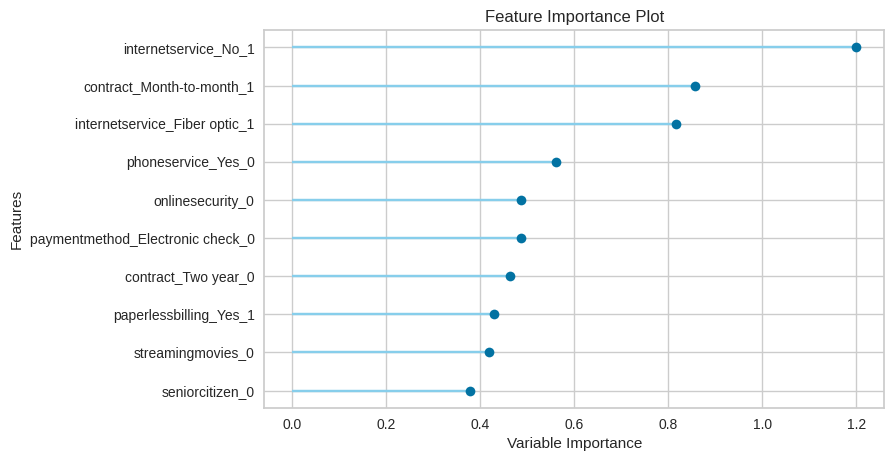

In [ ]:
plot_model(estimator = tuned_lr, plot = 'feature')

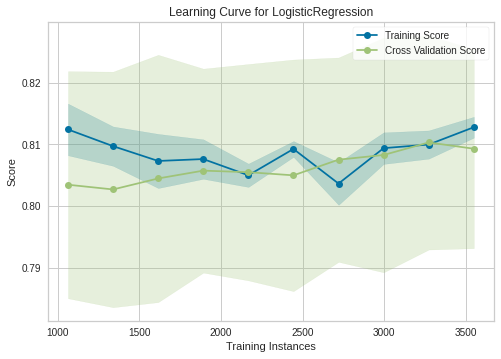

In [ ]:
plot_model(estimator = tuned_lr, plot = 'learning')

###modelos indiciduais

In [ ]:
df_train = df_train_dumy.copy()


In [ ]:
df_y = df_train['churn']

In [ ]:
df_train.drop(columns = 'churn', inplace = True)

In [ ]:
df_train.head()

seniorcitizen  onlinesecurity  streamingmovies  phoneservice_No  \
0              0               1                0                1   
1              0               0                0                0   
2              0               0                1                0   
3              0               0                1                0   
4              0               0                0                0   

   phoneservice_Yes  internetservice_Fiber optic  contract_Month-to-month  \
0                 0                            0                        0   
1                 1                            0                        0   
2                 1                            1                        0   
3                 1                            1                        1   
4                 1                            1                        1   

   paperlessbilling_No  paperlessbilling_Yes  paymentmethod_Mailed check  
0                    1                     0                           0  
1                    1                     0                           1  
2                    0                     1                           0  
3                    0                     1                           0  
4                    0                     1                           0

In [ ]:
df_train.columns

Index(['seniorcitizen', 'onlinesecurity', 'streamingmovies', 'phoneservice_No',
       'phoneservice_Yes', 'internetservice_Fiber optic',
       'contract_Month-to-month', 'paperlessbilling_No',
       'paperlessbilling_Yes', 'paymentmethod_Mailed check'],
      dtype='object')

In [ ]:
df_train.head()

seniorcitizen  onlinesecurity  streamingmovies  phoneservice_No  \
0              0               1                0                1   
1              0               0                0                0   
2              0               0                1                0   
3              0               0                1                0   
4              0               0                0                0   

   phoneservice_Yes  internetservice_Fiber optic  contract_Month-to-month  \
0                 0                            0                        0   
1                 1                            0                        0   
2                 1                            1                        0   
3                 1                            1                        1   
4                 1                            1                        1   

   paperlessbilling_No  paperlessbilling_Yes  paymentmethod_Mailed check  
0                    1                     0                           0  
1                    1                     0                           1  
2                    0                     1                           0  
3                    0                     1                           0  
4                    0                     1                           0

contract_Month-to-month 0.325905 5 tenure 0.236359 18 internetservice_Fiber optic 0.209766 27 paymentmethod_Electronic check 0.093502 19 internetservice_No 0.027997 22 contract_Two year 0.024558 13 monthlycharges 0.016333 14 totalcharges 0.012337 24 paperlessbilling_Yes 0.010585 2 seniorcitizen 0.010296 7 onlinesecurity 0.009703 23 paperlessbilling_No 0.008834 

In [ ]:
df_X = df_train

In [ ]:
from sklearn.model_selection import train_test_split
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(df_X, df_y, test_size = 0.3)

In [ ]:
X_treinamento.head()

seniorcitizen  onlinesecurity  streamingmovies  phoneservice_No  \
2420              0               0                1                0   
225               0               0                0                0   
2491              0               0                0                0   
4309              0               1                1                0   
272               0               0                0                0   

      phoneservice_Yes  internetservice_Fiber optic  contract_Month-to-month  \
2420                 1                            1                        1   
225                  1                            0                        0   
2491                 1                            0                        0   
4309                 1                            0                        0   
272                  1                            1                        1   

      paperlessbilling_No  paperlessbilling_Yes  paymentmethod_Mailed check  
2420                    0                     1                           0  
225                     0                     1                           1  
2491                    1                     0                           1  
4309                    1                     0                           0  
272                     0                     1                           0

In [ ]:
y_treinamento

2420    1
225     0
2491    0
4309    0
272     1
       ..
2970    0
3094    0
3596    1
3325    1
3015    0
Name: churn, Length: 3943, dtype: int64

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# Instancia...
ml_GB = GradientBoostingClassifier(n_estimators = 100, min_samples_split = 2)

# Treina... 
ml_GB.fit(X_treinamento, y_treinamento)

GradientBoostingClassifier()

In [ ]:
i_CV = 10

In [ ]:
# Cross-Validation com 10 folds
a_scores_CV = funcao_cross_val_score(ml_GB, X_treinamento, y_treinamento, i_CV)

Média das Acurácias calculadas pelo CV....: 77.91
std médio das Acurácias calculadas pelo CV: 1.9


In [ ]:
print(f'Acurácias: {a_scores_CV}')

Acurácias: [0.78734177 0.74683544 0.75443038 0.8071066  0.76649746 0.77918782
 0.76903553 0.78172589 0.80203046 0.79695431]


In [ ]:
# Faz precições...
y_pred = ml_GB.predict(X_teste)

In [ ]:
y_pred

array([1, 1, 0, ..., 0, 0, 0])

In [ ]:
def mostra_confusion_matrix(cf, 
                            group_names = None, 
                            categories = 'auto', 
                            count = True, 
                            percent = True, 
                            cbar = True, 
                            xyticks = False, 
                            xyplotlabels = True, 
                            sum_stats = True, 
                            figsize = (8, 8), 
                            cmap = 'Blues'):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

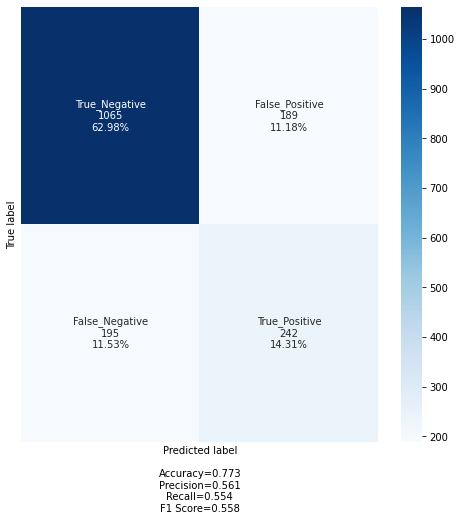

In [ ]:
# Confusion Matrix
cf_matrix = confusion_matrix(y_teste, y_pred)
cf_labels = ['True_Negative','False_Positive','False_Negative','True_Positive']
cf_categories = ['Zero', 'One']
mostra_confusion_matrix(cf_matrix, group_names = cf_labels, categories = cf_categories)

In [ ]:
l_colunas = X_treinamento.columns

In [ ]:
# Dicionário de parâmetros para o parameter tunning.
d_hiperparametros_GB= {'learning_rate': [ 0.01, 0.1, 0.15, 0.2, 0.3],
                  'n_estimators': [ 100, 150],
                  'max_depth': [2,3,4],
                  'min_samples_split': [1, 2, 3],
                  'min_samples_leaf': [1,2,3],
                  'random_state':[1323],
                  'presort':['deprecated'],
                  'max_features': list(range(1, X_treinamento.shape[1]))}

Fitting 10 folds for each of 2430 candidates, totalling 24300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.1998s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.0829s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done  86 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 122 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 166 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 210 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 262 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done 314 tasks      | elapsed:   26.0s
[Parallel(n_jo


GridSearchCV levou 2901.04 segundos.

Hiperparâmetros otimizados: {'learning_rate': 0.2, 'max_depth': 3, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'presort': 'deprecated', 'random_state': 1323}

GradientBoostingClassifier *********************************************************************************************************

********* CROSS-VALIDATION ***********
Média das Acurácias calculadas pelo CV....: 78.22
std médio das Acurácias calculadas pelo CV: 1.76

********* IMPORTÂNCIA DAS COLUNAS ***********
                        coluna  importancia
6      contract_Month-to-month     0.447826
5  internetservice_Fiber optic     0.282884
1               onlinesecurity     0.100962
0                seniorcitizen     0.051005
8         paperlessbilling_Yes     0.036725
7          paperlessbilling_No     0.035597
2              streamingmovies     0.020450
9   paymentmethod_Mailed check     0.018696
4             phoneservice_Yes     0.003232


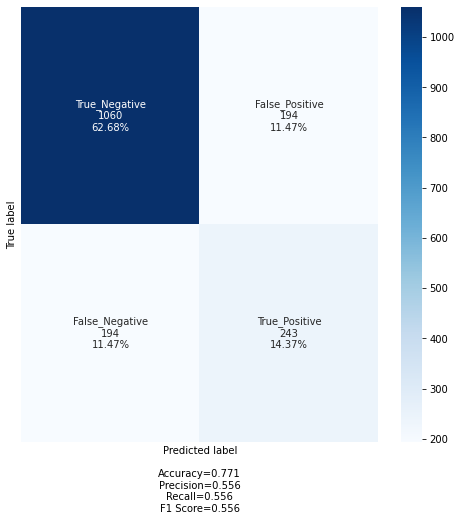

In [ ]:
# Invoca a função
ml_GB2, best_params= GridSearchOptimizer(ml_GB, 'ml_GB2', d_hiperparametros_GB, X_treinamento, y_treinamento, X_teste, y_teste, i_CV, l_colunas)

In [ ]:
best_params

{'learning_rate': 0.3,
 'max_depth': 2,
 'max_features': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 100}

In [ ]:
# Como o procedimento acima levou 93 minutos para executar, então vou estimar ml_GB2 abaixo usando os parâmetros acima estimados
best_params= {'learning_rate': 0.3, 'max_depth':2, 'max_features': 1, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}

#ml_GB2= GradientBoostingClassifier(learning_rate= best_params['learning_rate'], 
#                                      max_depth= best_params['max_depth'],
#                                      max_features= best_params['max_features'],
#                                      min_samples_leaf= best_params['min_samples_leaf'],
#                                      min_samples_split= best_params['min_samples_split'],
#                                      n_estimators= best_params['n_estimators'],
#                                      random_state= i_Seed)

ml_GB2= GradientBoostingClassifier(learning_rate= best_params['learning_rate'], 
                                      max_depth= best_params['max_depth'],
                                      min_samples_leaf= best_params['min_samples_leaf'],
                                      min_samples_split= best_params['min_samples_split'],
                                      n_estimators= best_params['n_estimators'])

In [ ]:
X_treinamento_GB, X_teste_GB = seleciona_colunas_relevantes(ml_GB2, X_treinamento, X_teste)


********** COLUNAS Relevantes ******
[1 3 4 5 7]


In [ ]:
X_treinamento.head()

seniorcitizen  ...  paymentmethod_Electronic check
5514              0  ...                               1
105               1  ...                               1
2598              0  ...                               0
2115              0  ...                               0
3069              0  ...                               0

[5 rows x 12 columns]

In [ ]:
X_treinamento_GB


array([[  62.  ,  100.15, 6283.3 ,    1.  ,    1.  ],
       [   5.  ,   74.35,  334.8 ,    1.  ,    1.  ],
       [  56.  ,  100.3 , 5614.45,    1.  ,    0.  ],
       ...,
       [  24.  ,   49.3 , 1233.25,    0.  ,    1.  ],
       [  37.  ,   19.5 ,  805.2 ,    0.  ,    1.  ],
       [   4.  ,   19.55,   68.8 ,    0.  ,    0.  ]])

In [ ]:
y_treinamento

5514    1
105     1
2598    1
2115    0
3069    0
       ..
518     1
874     0
1315    0
4890    0
5127    0
Name: churn, Length: 4507, dtype: int64

In [ ]:
best_params

{'learning_rate': 0.3,
 'max_depth': 2,
 'max_features': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 100}

In [ ]:
# Treina com as COLUNAS relevantes
ml_GB2.fit(X_treinamento_GB, y_treinamento)

# Cross-Validation com 10 folds
a_scores_CV = funcao_cross_val_score(ml_GB2, X_treinamento_GB, y_treinamento, i_CV)

Média das Acurácias calculadas pelo CV....: 79.72
std médio das Acurácias calculadas pelo CV: 1.49


In [ ]:
y_pred_GB = ml_GB2.predict(X_teste_GB)

# Calcula acurácia
accuracy_score(y_teste, y_pred_GB)

0.7799467613132209

In [ ]:
df_test_dumy.head()

id  gender  ...  paymentmethod_Electronic check  paymentmethod_Mailed check
0  5027       0  ...                               0                           0
1  1733       0  ...                               1                           0
2  5384       0  ...                               1                           0
3  6554       1  ...                               0                           0
4   364       1  ...                               0                           1

[5 rows x 29 columns]

In [ ]:
df_test_dumy.columns

Index(['id', 'gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'multiplelines', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'monthlycharges',
       'totalcharges', 'phoneservice_No', 'phoneservice_Yes',
       'internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No', 'contract_Month-to-month', 'contract_One year',
       'contract_Two year', 'paperlessbilling_No', 'paperlessbilling_Yes',
       'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check'],
      dtype='object')

In [ ]:
df_test_col_rev = df_test_dumy.copy()

In [ ]:
df_test_col_rev.drop(columns = ['id', 'gender', 'seniorcitizen', 'partner', 'dependents',
                                'multiplelines', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
                                'techsupport', 'streamingtv', 'streamingmovies', 'phoneservice_No',
                                'phoneservice_Yes', 'internetservice_DSL', 'internetservice_No',
                                'contract_One year', 'contract_Two year', 'paperlessbilling_No',
                                'paperlessbilling_Yes', 'paymentmethod_Bank transfer (automatic)',
                                'paymentmethod_Credit card (automatic)', 'paymentmethod_Electronic check',
                                'paymentmethod_Mailed check'], inplace=True)

In [ ]:
y_pred_GB = ml_GB2.predict(df_test_col_rev)

In [ ]:
y_pred_GB

array([0, 0, 0, ..., 0, 1, 0])

In [ ]:
pred_val = y_pred_GB

In [ ]:
from google.colab import files

In [ ]:
ids = df_churn_test['id']
output = pd.DataFrame({'id': ids, 'Churn': pred_val})
output.to_csv('submission39gb.csv', index=False)
files.download('submission39gb.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###XBC

In [ ]:
df_train_xgb = df_train_dumy.copy()

In [ ]:
df_y_xgb = df_train_xgb['churn']

In [ ]:
df_train_xgb.drop(columns='churn', inplace = True)

In [ ]:
df_X =df_train_xgb

In [ ]:
from sklearn.model_selection import train_test_split
X_treinamento, X_teste, y_treinamento, y_teste = train_test_split(df_X, df_y, test_size = 0.2)

In [ ]:
from xgboost import XGBClassifier
import xgboost as xgb

# Instancia...
ml_XGB = XGBClassifier(silent = False, 
                       scale_pos_weight=1,
                       learning_rate=0.01,  
                       colsample_bytree = 1,
                       subsample = 0.8,
                       objective='binary:logistic', 
                       n_estimators=1000, 
                       reg_alpha = 0.3,
                       max_depth= 3, 
                       gamma=1, 
                       max_delta_step=5)

n_estimators = 100 (100 caso o dataframe for grande. Se o dataframe for médio/pequeno, então 1000) - É o número de árvores desejamos construir;
max_depth= 3 - Determina quão profundo cada árvore pode crescer durante qualquer round de treinamento. Valores típicos no intervalo [3, 10];
learning rate= 0.01 - Usado para evitar overfitting, intervalo: [0, 1];
alpha (somente para problemas de Regressão) - L1 regularization nos pesos. Valores altos resulta em mais regularization;
lambda (somente para problemas de Regressão) - L2 regularization nos pesos.
colsample_bytree: 1 - porcentagem de COLUNAS usados por cada árvore. Alto valor pode causar overfitting;
subsample: 0.8 - porcentagem de amostras usadas por árvore. Um valor baixo pode levar a overfitting;
gamma: 1 - Controla se um determinado nó será dividido com base na redução esperada na perda após a divisão. Um valor mais alto leva a menos divisões.
objective: Define a "loss function". As opções são:
reg:linear - Para resolver problemas de regressão;
reg:logistic - Para resolver problemas de classificação;
binary:logistic - Para resolver problemas de classificação com cálculo de probabilidades;

In [ ]:
# Treina...
ml_XGB.fit(X_treinamento, y_treinamento)

In [ ]:
# Cross-Validation com 10 folds
a_scores_CV = funcao_cross_val_score(ml_XGB, X_treinamento, y_treinamento, i_CV)

In [ ]:
print(f'Acurácias: {a_scores_CV}')

In [ ]:
# Faz predições...
y_pred = ml_XGB.predict(X_teste)

In [ ]:
# Confusion Matrix
cf_matrix = confusion_matrix(y_teste, y_pred)
cf_labels = ['True_Negative','False_Positive','False_Negative','True_Positive']
cf_categories = ['Zero', 'One']
mostra_confusion_matrix(cf_matrix, group_names= cf_labels, categories= cf_categories)

In [ ]:
# Dicionário de Hiperparâmetros para XGBoost:
d_hiperparametros_XGB = {'min_child_weight': [i for i in np.arange(1, 13)]} #,
#                'gamma': [i for i in np.arange(0, 5, 0.5)],
#                'subsample': [0.6, 0.8, 1.0],
#                'colsample_bytree': [0.6, 0.8, 1.0],
#                'max_depth': [3, 4, 5, 7, 9],
#                'learning_rate': [i for i in np.arange(0.01, 1, 0.1)]}

In [ ]:
# Invoca a função
ml_XGB, best_params= GridSearchOptimizer(ml_XGB, 'ml_XGB2', d_hiperparametros_XGB, X_treinamento, y_treinamento, X_teste, y_teste, i_CV, l_colunas)

In [ ]:
# Como o procedimento acima levou 372 minutos para executar, então vou estimar ml_XGB2 abaixo usando os parâmetros acima estimados
best_params= {'colsample_bytree': 0.8, 'gamma': 0.5, 'learning_rate': 0.51, 'max_depth': 5, 'min_child_weight': 1, 'subsample': 0.6}

ml_XGB2= XGBClassifier(min_child_weight= best_params['min_child_weight'], 
                       gamma= best_params['gamma'], 
                       subsample= best_params['subsample'], 
                       colsample_bytree= best_params['colsample_bytree'], 
                       max_depth= best_params['max_depth'], 
                       learning_rate= best_params['learning_rate'], 
                       random_state= i_Seed)

In [ ]:
df_importantes = pd.DataFrame(zip(X_treinamento.columns, ml_XGB.feature_importances_), columns = ['coluna', 'importancia'])
df_importantes.sort_values(by = 'importancia', ascending = False)

In [ ]:
# Gráfico das features mais importantes:
from xgboost import plot_importance

xgb.plot_importance(ml_XGB2, color = 'red')
plt.title('importance', fontsize = 20)
plt.yticks(fontsize = 10)
plt.ylabel('features', fontsize = 20)

In [ ]:
ml_XGB2

In [ ]:
X_treinamento_XGB, X_teste_XGB= seleciona_colunas_relevantes(ml_XGB2, X_treinamento, X_teste)

In [ ]:
best_params

In [ ]:
# Treina com as COLUNAS relevantes...
ml_XGB2.fit(X_treinamento_XGB, y_treinamento)

# Cross-Validation com 10 folds
a_scores_CV = funcao_cross_val_score(ml_XGB2, X_treinamento_XGB, y_treinamento, i_CV)

In [ ]:
y_pred_XGB = ml_XGB2.predict(X_teste_XGB)

# Calcula acurácia
accuracy_score(y_teste, y_pred_XGB)

In [ ]:
xgb.to_graphviz(ml_XGB2)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logreg = LogisticRegression()
logreg.fit(X_treinamento, y_treinamento)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
import statsmodels.api as sm

In [ ]:
X2_treinamento = sm.add_constant(X_treinamento)
lm_sm = sm.OLS(y_treinamento, X2_treinamento).fit()
print(lm_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.300
Model:                            OLS   Adj. R-squared:                  0.296
Method:                 Least Squares   F-statistic:                     79.95
Date:                Sun, 15 Nov 2020   Prob (F-statistic):          4.94e-324
Time:                        04:11:24   Log-Likelihood:                -1900.3
No. Observations:                4507   AIC:                             3851.
Df Residuals:                    4482   BIC:                             4011.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
X2_treinamento.columns

Index(['const', 'id', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'multiplelines', 'onlinesecurity', 'onlinebackup',
       'deviceprotection', 'techsupport', 'streamingtv', 'streamingmovies',
       'monthlycharges', 'totalcharges', 'phoneservice_No', 'phoneservice_Yes',
       'internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No', 'contract_Month-to-month', 'contract_One year',
       'contract_Two year', 'paperlessbilling_No', 'paperlessbilling_Yes',
       'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check'],
      dtype='object')

In [ ]:
X3 = X_treinamento.drop(columns = ['id', 'gender', 'partner', 'dependents',
       'onlinesecurity', 'onlinebackup', 'techsupport','phoneservice_No',
       'internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No'], axis = 1)

X3_treinamento = sm.add_constant(X3)
lm_sm2 = sm.OLS(y_treinamento, X3_treinamento).fit()
print(lm_sm2.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.278
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     115.4
Date:                Sun, 15 Nov 2020   Prob (F-statistic):          8.11e-304
Time:                        04:28:02   Log-Likelihood:                -1968.5
No. Observations:                4507   AIC:                             3969.
Df Residuals:                    4491   BIC:                             4072.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------

In [ ]:
X4 = X3_treinamento.drop(columns = ['deviceprotection', 'streamingtv', 'streamingmovies',
                                    'contract_Two year', 'paperlessbilling_No',
                                    'paymentmethod_Credit card (automatic)',
                                    'paymentmethod_Bank transfer (automatic)'], axis = 1)
X4_treinamento = sm.add_constant(X4)
lm_sm3 = sm.OLS(y_treinamento, X4_treinamento).fit()
print(lm_sm3.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     156.9
Date:                Sun, 15 Nov 2020   Prob (F-statistic):          4.02e-307
Time:                        04:33:25   Log-Likelihood:                -1970.9
No. Observations:                4507   AIC:                             3966.
Df Residuals:                    4495   BIC:                             4043.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
X5 = X4_treinamento.drop(columns = ['contract_One year', 'paymentmethod_Mailed check'], axis = 1)
X5_treinamento = sm.add_constant(X5)
lm_sm4 = sm.OLS(y_treinamento, X5_treinamento).fit()
print(lm_sm4.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     191.4
Date:                Sun, 15 Nov 2020   Prob (F-statistic):          1.27e-308
Time:                        04:37:10   Log-Likelihood:                -1972.7
No. Observations:                4507   AIC:                             3965.
Df Residuals:                    4497   BIC:                             4030.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
X6 = X5_treinamento.drop(columns = ['tenure'], axis = 1)
X6_treinamento = sm.add_constant(X6)
lm_sm5 = sm.OLS(y_treinamento, X6_treinamento).fit()
print(lm_sm5.summary())

                            OLS Regression Results                            
Dep. Variable:                  churn   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     214.7
Date:                Sun, 15 Nov 2020   Prob (F-statistic):          4.93e-309
Time:                        04:39:41   Log-Likelihood:                -1974.5
No. Observations:                4507   AIC:                             3967.
Df Residuals:                    4498   BIC:                             4025.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [ ]:
df_train_dumy.columns

Index(['id', 'gender', 'seniorcitizen', 'partner', 'dependents', 'tenure',
       'multiplelines', 'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies', 'monthlycharges',
       'totalcharges', 'churn', 'phoneservice_No', 'phoneservice_Yes',
       'internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No', 'contract_Month-to-month', 'contract_One year',
       'contract_Two year', 'paperlessbilling_No', 'paperlessbilling_Yes',
       'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Electronic check', 'paymentmethod_Mailed check'],
      dtype='object')

In [ ]:
df_model_train  = df_train_dumy.drop(columns = ['id', 'gender', 'partner', 'dependents', 'tenure',
       'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies',
       'phoneservice_No', 'internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No', 'contract_One year',
       'contract_Two year', 'paperlessbilling_No',
       'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Mailed check'], axis = 1)

In [ ]:
df_model_train.head()

seniorcitizen  ...  paymentmethod_Electronic check
0              0  ...                               0
1              0  ...                               0
2              0  ...                               0
3              0  ...                               0
4              0  ...                               1

[5 rows x 9 columns]

In [ ]:
df_model_test  = df_test_dumy.drop(columns = ['id', 'gender', 'partner', 'dependents', 'tenure',
       'onlinesecurity', 'onlinebackup', 'deviceprotection',
       'techsupport', 'streamingtv', 'streamingmovies',
       'phoneservice_No', 'internetservice_DSL', 'internetservice_Fiber optic',
       'internetservice_No', 'contract_One year',
       'contract_Two year', 'paperlessbilling_No',
       'paymentmethod_Bank transfer (automatic)',
       'paymentmethod_Credit card (automatic)',
       'paymentmethod_Mailed check'], axis = 1)

In [ ]:
df_model_test.head()

seniorcitizen  ...  paymentmethod_Electronic check
0              0  ...                               0
1              1  ...                               0
2              0  ...                               1
3              0  ...                               0
4              0  ...                               0

[5 rows x 8 columns]

In [ ]:
df_model_train.columns

Index(['seniorcitizen', 'multiplelines', 'monthlycharges', 'totalcharges',
       'churn', 'phoneservice_Yes', 'contract_Month-to-month',
       'paperlessbilling_Yes', 'paymentmethod_Electronic check'],
      dtype='object')

###automl2

In [ ]:
clf = setup(data = df_model_train,
            target = 'churn',
            #numeric_features = ['tenure', 'monthlycharges', 'totalcharges'] 
            #numeric_imputation = 'mean'
            categorical_features = ['seniorcitizen', 'multiplelines', 'monthlycharges',
                                    'totalcharges', 'phoneservice_Yes', 'contract_Month-to-month',
                                    'paperlessbilling_Yes', 'paymentmethod_Electronic check'], # lista das variáveis categóricas
            silent = False)

Description             Value
0                               session_id              5311
1                                   Target             churn
2                              Target Type            Binary
3                            Label Encoded        0: 0, 1: 1
4                            Original Data         (5634, 9)
5                           Missing Values             False
6                         Numeric Features                 0
7                     Categorical Features                 8
8                         Ordinal Features             False
9                High Cardinality Features             False
10                 High Cardinality Method              None
11                   Transformed Train Set      (3943, 4652)
12                    Transformed Test Set      (1691, 4652)
13                      Shuffle Train-Test              True
14                     Stratify Train-Test             False
15                          Fold Generator   StratifiedKFold
16                             Fold Number                10
17                                CPU Jobs                -1
18                                 Use GPU             False
19                          Log Experiment             False
20                         Experiment Name  clf-default-name
21                                     USI              a915
22                         Imputation Type            simple
23          Iterative Imputation Iteration              None
24                         Numeric Imputer              mean
25      Iterative Imputation Numeric Model              None
26                     Categorical Imputer          constant
27  Iterative Imputation Categorical Model              None
28           Unknown Categoricals Handling    least_frequent
29                               Normalize             False
30                        Normalize Method              None
31                          Transformation             False
32                   Transformation Method              None
33                                     PCA             False
34                              PCA Method              None
35                          PCA Components              None
36                     Ignore Low Variance             False
37                     Combine Rare Levels             False
38                    Rare Level Threshold              None
39                         Numeric Binning             False
40                         Remove Outliers             False
41                      Outliers Threshold              None
42                Remove Multicollinearity             False
43             Multicollinearity Threshold              None
44                              Clustering             False
45                    Clustering Iteration              None
46                     Polynomial Features             False
47                       Polynomial Degree              None
48                    Trignometry Features             False
49                    Polynomial Threshold              None
50                          Group Features             False
51                       Feature Selection             False
52            Features Selection Threshold              None
53                     Feature Interaction             False
54                           Feature Ratio             False
55                   Interaction Threshold              None
56                           Fix Imbalance             False
57                    Fix Imbalance Method             SMOTE

In [ ]:
compare_models()

Model  Accuracy     AUC  Recall   Prec.  \
catboost              CatBoost Classifier    0.7659  0.7969  0.4156  0.5810   
xgboost         Extreme Gradient Boosting    0.7603  0.7960  0.4320  0.5602   
gbc          Gradient Boosting Classifier    0.7583  0.7945  0.4059  0.5608   
lightgbm  Light Gradient Boosting Machine    0.7583  0.7967  0.4386  0.5541   
lr                    Logistic Regression    0.7570  0.7954  0.3935  0.5614   
ada                  Ada Boost Classifier    0.7532  0.7829  0.4290  0.5429   
ridge                    Ridge Classifier    0.7484  0.0000  0.3619  0.5377   
et                 Extra Trees Classifier    0.7484  0.7461  0.2505  0.5573   
rf               Random Forest Classifier    0.7479  0.7621  0.1948  0.5712   
dt               Decision Tree Classifier    0.7451  0.6247  0.3694  0.5254   
svm                   SVM - Linear Kernel    0.7431  0.0000  0.3908  0.5190   
knn                K Neighbors Classifier    0.7332  0.7188  0.3638  0.4962   
lda          Linear Discriminant Analysis    0.5720  0.5416  0.2514  0.3584   
nb                            Naive Bayes    0.4514  0.5221  0.6718  0.2779   
qda       Quadratic Discriminant Analysis    0.2643  0.0000  1.0000  0.2643   

              F1   Kappa     MCC  TT (Sec)  
catboost  0.4840  0.3381  0.3463    15.497  
xgboost   0.4873  0.3345  0.3395    50.329  
gbc       0.4687  0.3181  0.3260    16.577  
lightgbm  0.4890  0.3338  0.3380     0.468  
lr        0.4615  0.3109  0.3198     2.338  
ada       0.4774  0.3194  0.3241     4.912  
ridge     0.4317  0.2781  0.2876     1.735  
et        0.3434  0.2152  0.2424    10.891  
rf        0.2884  0.1786  0.2175     7.677  
dt        0.4295  0.2737  0.2822     1.420  
svm       0.4431  0.2816  0.2875     1.120  
knn       0.4186  0.2511  0.2568    17.189  
lda       0.2892  0.1511  0.1573    48.473  
nb        0.3931  0.0306  0.0403     0.316  
qda       0.4181  0.0000  0.0000    30.610

In [ ]:
xb = create_model('xgboost')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7367  0.7816  0.3429  0.5070  0.4091  0.2478  0.2556
1       0.7696  0.8015  0.4286  0.5921  0.4972  0.3528  0.3605
2       0.7823  0.8107  0.4712  0.6125  0.5326  0.3938  0.3996
3       0.7741  0.8472  0.4808  0.5882  0.5291  0.3825  0.3859
4       0.7437  0.7663  0.4423  0.5169  0.4767  0.3083  0.3099
5       0.7817  0.8195  0.4808  0.6098  0.5376  0.3974  0.4022
6       0.7487  0.7890  0.3942  0.5325  0.4530  0.2946  0.3002
7       0.7411  0.7646  0.4135  0.5119  0.4574  0.2900  0.2928
8       0.7690  0.7976  0.4615  0.5783  0.5134  0.3644  0.3684
9       0.7563  0.7819  0.4038  0.5526  0.4667  0.3137  0.3202
Mean    0.7603  0.7960  0.4320  0.5602  0.4873  0.3345  0.3395
SD      0.0163  0.0240  0.0422  0.0390  0.0398  0.0482  0.0479

In [ ]:
tuned_xb = tune_model(xb)

IntProgress(value=0, description='Processing: ', max=7)

Initiated  . . . . . . . . . . . . . . . . . .                   05:50:48
Status     . . . . . . . . . . . . . . . . . .  Searching Hyperparameters
Estimator  . . . . . . . . . . . . . . . . . .  Extreme Gradient Boosting

Empty DataFrame
Columns: [Accuracy, AUC, Recall, Prec., F1, Kappa, MCC]
Index: []

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


KeyboardInterrupt: ignored

In [ ]:
predic = predict_model(tuned_xb, data = df_model_test)
predic

In [ ]:
predic['Score'].mean()

In [ ]:
predic['Score'].std()

In [ ]:
pred_val = predic['Label']

In [ ]:
ids = df_churn_test['id']
output = pd.DataFrame({'id': ids, 'Churn': pred_val})
output.to_csv('submission37cat.csv', index=False)
files.download('submission37cat.csv')